# Capstone Project

## Introduction
The business care here is a bit different than previous projects.  Rather than focusing solely on an in depth analysis of the data in order to answer a question, my goal is to create a data tool and incorporate the analysis into that. Specifically, I would like to create an interface that provides a wealth of information about stock market prices.  It should be simple to use and provide a high level of interactivity.  As this is a data science project, there will also be an emphasis on machine learning and how it could be used to predict future prices.  Additionally, there were two specific topics I wanted to examine and visualize, these were yield rates and economic sectors.

In [1]:
#Importing the necessary packages
import re
import os
import math
from io import StringIO
from datetime import datetime, timedelta, date
from urllib.error import HTTPError
import statsmodels.stats as smstat
import requests
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import random
import statistics as stats
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
from matplotlib.pylab import rcParams
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import random
import itertools
from sklearn.metrics import mean_squared_error
from math import sqrt, log
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import tensorflow as tf
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from ipywidgets import widgets
from ipywidgets import interact, interact_manual
from IPython.display import display
%matplotlib inline

In [2]:
#Creating a class in order to scrape data from Yahoo Finance
class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])

In [3]:
#Defining a root mean squared error function for later
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(round(rmse, 3)))

In [4]:
#importing stock exchange datasets
nasdaq_df = pd.read_csv('nasdaq_list.csv')
nyse_df = pd.read_csv('nyse_list.csv')
nasdaq_df['exchange'] = 'nasdaq'
nyse_df['exchange'] = 'nyse'
comb_names = pd.concat([nyse_df, nasdaq_df], ignore_index=True)
comb_names.rename(str.lower, axis='columns', inplace=True)
comb_names.head()

,symbol,name,lastsale,marketcap,ipoyear,sector,industry,summary quote,exchange
0,DDD,3D Systems Corporation,6.69,$810.39M,NaN,Technology,Computer Software: Prepackaged Software,https://old.nasdaq.com/symbol/ddd,nyse
1,MMM,3M Company,169.30,$97.52B,NaN,Health Care,Medical/Dental Instruments,https://old.nasdaq.com/symbol/mmm,nyse
2,WBAI,500.com Limited,2.98,$128.14M,2013.0,Consumer Services,Services-Misc. Amusement & Recreation,https://old.nasdaq.com/symbol/wbai,nyse
3,EGHT,8x8 Inc,16.49,$1.72B,NaN,Technology,EDP Services,https://old.nasdaq.com/symbol/eght,nyse
4,AHC,A.H. Belo Corporation,1.45,$34.63M,NaN,Consumer Services,Newspapers/Magazines,https://old.nasdaq.com/symbol/ahc,nyse


# Data Cleaning / Feature Engineering

In [5]:
#Listing and dropping duplicates
dupe_list = comb_names.duplicated(subset=['symbol'])
dupes = []
for x in range(len(dupe_list)):
    if dupe_list[x] == True:
        dupes.append(x)
new_names = comb_names.drop(dupes)
new_names.reset_index(drop=True, inplace=True)
new_names.head()

,symbol,name,lastsale,marketcap,ipoyear,sector,industry,summary quote,exchange
0,DDD,3D Systems Corporation,6.69,$810.39M,NaN,Technology,Computer Software: Prepackaged Software,https://old.nasdaq.com/symbol/ddd,nyse
1,MMM,3M Company,169.30,$97.52B,NaN,Health Care,Medical/Dental Instruments,https://old.nasdaq.com/symbol/mmm,nyse
2,WBAI,500.com Limited,2.98,$128.14M,2013.0,Consumer Services,Services-Misc. Amusement & Recreation,https://old.nasdaq.com/symbol/wbai,nyse
3,EGHT,8x8 Inc,16.49,$1.72B,NaN,Technology,EDP Services,https://old.nasdaq.com/symbol/eght,nyse
4,AHC,A.H. Belo Corporation,1.45,$34.63M,NaN,Consumer Services,Newspapers/Magazines,https://old.nasdaq.com/symbol/ahc,nyse


In [6]:
#Data cleaning- filtering out small companies, dropping columns, 
#Dropping NA values
mid_cap = new_names.copy()
drop_list = []
for x in range(len(mid_cap['marketcap'])):
    cap_value = str(mid_cap['marketcap'][x])
    if cap_value[-1] == 'M':
        drop_list.append(x)
    elif cap_value[-1] == 'B' and cap_value[:3] == '$1.':
        drop_list.append(x)
mid_cap.drop(drop_list, inplace=True)
mid_cap = mid_cap[mid_cap['marketcap'].notna()]
mid_cap = mid_cap[mid_cap['sector'].notna()]
mid_cap = mid_cap.drop(columns=['ipoyear', 'lastsale', 'summary quote', 'industry'])
mid_cap.reset_index(drop=True, inplace=True)
mid_cap.head()

,symbol,name,marketcap,sector,exchange
0,MMM,3M Company,$97.52B,Health Care,nyse
1,AOS,A.O Smith Corporation,$9.23B,Consumer Durables,nyse
2,AAN,"Aaron&#39;s, Inc.",$3.94B,Technology,nyse
3,ABB,ABB Ltd,$57.15B,Consumer Durables,nyse
4,ABT,Abbott Laboratories,$194.14B,Health Care,nyse


In [7]:
#Getting list of all symbols and using it to scrape the web for stock data
symbol_list = mid_cap['symbol']
for x in symbol_list:
    try:
        temp_df = YahooFinanceHistory(x, days_back=365).get_quote()
        temp_df['symbol'] = x
        if x == symbol_list[0]:
            new_df = temp_df
        else:
            new_df = pd.concat([new_df, temp_df], ignore_index=True)
    except:
        continue 

In [8]:
#Dropping NaN stocks
midcap_data = new_df.copy()
na_stocks = midcap_data[midcap_data['Open'].isna()]
na_unique = na_stocks['symbol'].unique()
for x in na_unique:
    na_temp = midcap_data[midcap_data['symbol'] == x]
    midcap_data.drop(na_temp.index, inplace=True)

In [225]:
#Quick list of unique dates in the dataset
#Removing stocks that don't cover the full date range
date_list = np.array(midcap_data['Date'].unique(), dtype='datetime64[D]')
for x in midcap_data['symbol'].unique():
    temp_df = midcap_data[midcap_data['symbol']==x]
    if temp_df['Date'].min() > min(date_list):
        midcap_data.drop(temp_df.index, inplace=True)

In [230]:
#Line to export midcap_data, currently marked as comment
#Because it has already been exported
#midcap_data.to_csv(r'C:\Users\derek\capstone_project\midcap_data.csv',index=False, header=True)

In [226]:
#Making columns lowercase, removing spacing
test_ind = midcap_data.copy()
test_ind.rename(str.lower, axis='columns', inplace=True)
test_ind.rename(columns={'adj close':'adj_close'}, inplace=True)
test_ind = test_ind.set_index(['symbol', 'date'])
test_ind.head()

open        high         low       close   adj_close  \
symbol date                                                                     
MMM    2019-10-31  168.509995  168.559998  163.550003  164.990005  159.066010   
       2019-11-01  166.940002  170.149994  166.720001  170.089996  163.982880   
       2019-11-04  171.619995  175.000000  171.619995  174.899994  168.620193   
       2019-11-05  175.000000  175.460007  173.770004  175.270004  168.976898   
       2019-11-06  174.910004  175.000000  172.360001  174.000000  167.752502   

                      volume  
symbol date                   
MMM    2019-10-31  2653100.0  
       2019-11-01  2467400.0  
       2019-11-04  4142800.0  
       2019-11-05  2304300.0  
       2019-11-06  3012900.0

In [10]:
#Setting multiindex and adding two new columns
test_ind2 = test_ind.copy()
test_ind2['diff'] = 0
multi_index = pd.MultiIndex.from_tuples(test_ind2.index, names=['symbol', 'date'])
test_ind2.reindex(multi_index)
test_ind2.sort_index(level=['symbol','date'], ascending=True, inplace=True)
test_ind2['diff'] = test_ind2['close'] - test_ind2['open']
test_ind2['pct_change'] = test_ind2['diff'] / test_ind2['open'] *100
test_ind2.head()

open       high        low      close  adj_close  \
symbol date                                                                
A      2019-10-31  76.000000  76.120003  75.099998  75.750000  75.105080   
       2019-11-01  76.510002  77.349998  76.320000  76.970001  76.314690   
       2019-11-04  77.680000  77.849998  76.730003  76.739998  76.086647   
       2019-11-05  76.820000  76.910004  75.470001  75.550003  74.906784   
       2019-11-06  75.699997  75.940002  74.940002  75.790001  75.144737   

                      volume      diff  pct_change  
symbol date                                         
A      2019-10-31   970500.0 -0.250000   -0.328947  
       2019-11-01  1106300.0  0.459999    0.601227  
       2019-11-04  1010200.0 -0.940002   -1.210095  
       2019-11-05  2362700.0 -1.269997   -1.653211  
       2019-11-06  1355700.0  0.090004    0.118896

In [11]:
#Creating a moving average column
test_ind2['move_avg_7'] = 0
for x,y in test_ind2.index:
    if y >= test_ind2.index[4][1]:
        if y.weekday() != 4:
            first_day = y - timedelta(days=6)
            test_ind2.loc[(x, y),'move_avg_7'] = \
            test_ind2.loc[(x, first_day):(x, y), 'pct_change'].mean()
        elif y.weekday() == 4:
            first_day = y - timedelta(days=4) 
            test_ind2.loc[(x, y),'move_avg_7'] = \
            test_ind2.loc[(x, first_day):(x, y), 'pct_change'].mean()
        
test_ind2.head()

open       high        low      close  adj_close  \
symbol date                                                                
A      2019-10-31  76.000000  76.120003  75.099998  75.750000  75.105080   
       2019-11-01  76.510002  77.349998  76.320000  76.970001  76.314690   
       2019-11-04  77.680000  77.849998  76.730003  76.739998  76.086647   
       2019-11-05  76.820000  76.910004  75.470001  75.550003  74.906784   
       2019-11-06  75.699997  75.940002  74.940002  75.790001  75.144737   

                      volume      diff  pct_change  move_avg_7  
symbol date                                                     
A      2019-10-31   970500.0 -0.250000   -0.328947    0.000000  
       2019-11-01  1106300.0  0.459999    0.601227    0.000000  
       2019-11-04  1010200.0 -0.940002   -1.210095    0.000000  
       2019-11-05  2362700.0 -1.269997   -1.653211    0.000000  
       2019-11-06  1355700.0  0.090004    0.118896   -0.494426

In [13]:
#Finding the difference between each stock's start and end date
sym_list = list(test_ind2.index.get_level_values(0).unique())
delta_list = []
for x in sym_list:
    start_val = test_ind2.loc[(x, test_ind2.loc[x].index.min()), 'open']
    end_val = test_ind2.loc[(x, test_ind2.loc[x].index.max()), 'close'] 
    delta_list.append(end_val-start_val)
deltarray = np.array(delta_list)

In [14]:
#Creating a reference dataframe for time independent columns
sym_delta = pd.DataFrame({'symbol':sym_list, 'delta':deltarray})
sym_delta.set_index('symbol', drop=True, inplace=True)
new_midcap = mid_cap.set_index('symbol', drop=True)
sym_delta['sector'] = 0
sym_delta['exchange'] = 0
for x in sym_delta.index:
    sym_delta.loc[x,'sector'] = new_midcap.loc[x, 'sector']
    sym_delta.loc[x,'exchange'] = new_midcap.loc[x, 'exchange']
sym_delta.head()

,delta,sector,exchange
symbol,,,
A,26.019997,Capital Goods,nyse
AA,-8.190001,Basic Industries,nyse
AAL,-18.910000,Transportation,nasdaq
AAN,-21.980000,Technology,nyse
AAON,12.329998,Capital Goods,nasdaq


In [15]:
#Adding several new columns to the dataframe
test_ind2['delta'] = 0
test_ind2['delta_pct'] = 0
test_ind2['sector'] = 0
test_ind2['exchange'] = 0
for x in sym_delta.index:
    test_ind2.loc[x, 'delta'] = sym_delta.loc[x, 'delta']
    test_ind2.loc[x, 'sector'] = sym_delta.loc[x, 'sector']
    test_ind2.loc[x, 'exchange'] = sym_delta.loc[x, 'exchange']
    test_ind2.loc[x, 'delta_pct'] = sym_delta.loc[x, 'delta'] \
    / test_ind2.loc[(x, test_ind2.loc[x].index.min()), 'open'] *100

In [16]:
#Dropping columns used for calculations
#And other unneeded columns
test_ind3 = test_ind2.copy()
test_ind3['intra_rng'] = test_ind3['high'] - test_ind3['low']
test_ind3['intra_pct'] = test_ind3['intra_rng'] / test_ind3['open'] *100
test_ind3.drop(columns=['high', 'low', 'adj_close', 'volume', 'diff', 'delta', 'intra_rng'], inplace=True)
test_ind3.head()

open      close  pct_change  move_avg_7  delta_pct  \
symbol date                                                                  
A      2019-10-31  76.000000  75.750000   -0.328947    0.000000  34.236838   
       2019-11-01  76.510002  76.970001    0.601227    0.000000  34.236838   
       2019-11-04  77.680000  76.739998   -1.210095    0.000000  34.236838   
       2019-11-05  76.820000  75.550003   -1.653211    0.000000  34.236838   
       2019-11-06  75.699997  75.790001    0.118896   -0.494426  34.236838   

                          sector exchange  intra_pct  
symbol date                                           
A      2019-10-31  Capital Goods     nyse   1.342112  
       2019-11-01  Capital Goods     nyse   1.346227  
       2019-11-04  Capital Goods     nyse   1.441806  
       2019-11-05  Capital Goods     nyse   1.874516  
       2019-11-06  Capital Goods     nyse   1.321004

In [17]:
#Creating a dataframe of only the last date
#Also making one for the first date
for x in sym_delta.index:
    open_val = pd.DataFrame(test_ind3.loc[(x, test_ind3.loc[x].index.min())]) 
    close_val = pd.DataFrame(test_ind3.loc[(x, test_ind3.loc[x].index.max())]) 
    if x == sym_delta.index[0]:
        open_df = open_val.T
        close_df = close_val.T
    else:
        open_df = pd.concat([open_df, open_val.T])
        close_df = pd.concat([close_df, close_val.T])
close_df.head()

,,open,close,pct_change,move_avg_7,delta_pct,sector,exchange,intra_pct
A,2020-10-29,102.27,102.02,-0.244451,-0.742499,34.2368,Capital Goods,nyse,2.23428
AA,2020-10-29,12.21,12.75,4.4226,-0.0552178,-39.1118,Basic Industries,nyse,5.24161
AAL,2020-10-29,10.96,11.16,1.82482,-2.11402,-62.8866,Transportation,nasdaq,3.64964
AAN,2020-10-29,54.95,54.76,-0.345774,-0.764469,-28.6422,Technology,nyse,7.91628
AAON,2020-10-29,57.1,58.98,3.29247,-0.07755,26.4309,Capital Goods,nasdaq,4.60596


In [18]:
#Creating a dataframe with summary statistics
pct_change_list = []
delta_pct_list = []
intra_pct_list = []
sector_summ_list = []
exchange_list = []
for x in sym_delta.index:
    pct_change_list.append(test_ind3.loc[x, 'pct_change'].mean())
    delta_pct_list.append(test_ind3.loc[x, 'delta_pct'].mean())
    intra_pct_list.append(test_ind3.loc[x, 'intra_pct'].mean())
    sector_summ_list.append(close_df.loc[x, 'sector'][-1])
    exchange_list.append(close_df.loc[x, 'exchange'][-1])
summ_val = {'pct_change':pct_change_list, \
           'delta_pct':delta_pct_list, \
           'intra_pct':intra_pct_list, \
           'sector':sector_summ_list, \
           'exchange':exchange_list}
summary_df = pd.DataFrame(summ_val, index=sym_delta.index)
summary_df.head()

,pct_change,delta_pct,intra_pct,sector,exchange
symbol,,,,,
A,0.123025,34.236838,2.376618,Capital Goods,nyse
AA,-0.210734,-39.111751,5.697919,Basic Industries,nyse
AAL,-0.580924,-62.886598,6.465470,Transportation,nasdaq
AAN,-0.142530,-28.642169,5.012361,Technology,nyse
AAON,0.179401,26.430863,3.699973,Capital Goods,nasdaq


In [20]:
#Creating a custom frequency by importing the Federal holidays
#And adding/subtracting the stock exchange dates
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=min(date_list), end=max(date_list))
updated_holidays = list(holidays)
updated_holidays.append(datetime(2020, 4, 10))
updated_holidays = np.array(updated_holidays, dtype='datetime64[D]')
updated_holidays = np.delete(updated_holidays, [0,9])
bday_us = pd.offsets.CustomBusinessDay(holidays=updated_holidays)
dt_index = pd.DatetimeIndex(date_list, freq=bday_us)

In [21]:
#Creating a quick list of sectors
sector_list = list(test_ind3['sector'].unique())
sector_list.sort()

In [22]:
#Storing sector averages in a dictionary
date_dict = {}
for x in sector_list:
    temp_subset = test_ind3[test_ind3['sector'] == x]
    dict_append = {}
    for y in date_list:
        temp_pct = []
        temp_intra = []
        temp_delta = []
        for z in temp_subset.index:
            if z[1] == y:
                temp_pct.append(temp_subset.loc[z, 'pct_change'])
                temp_intra.append(temp_subset.loc[z, 'intra_pct'])
                temp_delta.append(temp_subset.loc[z, 'delta_pct'])
        pct_mean = stats.mean(temp_pct)
        intra_mean = stats.mean(temp_intra)
        delta_mean = stats.mean(temp_delta)
        dict_append[y] = [pct_mean, intra_mean, delta_mean]
    date_dict[x] = dict_append

In [23]:
#Creating a new dataframe to hold sector averages
sector_df = pd.DataFrame.from_dict({(i,j): date_dict[i][j] 
                           for i in date_dict.keys() 
                           for j in date_dict[i].keys()},
                       orient='index', columns=['pct_change', 'intra_pct', 'delta_pct'])

In [24]:
#Creating a dictionary to split the tuple index
sect_index = []
date_index = []
for x,y in sector_df.index:
    sect_index.append(x)
    date_index.append(y)
index_dict = {'sector':sect_index, 'date':date_index}
index_df = pd.DataFrame(index_dict)

In [25]:
#Setting a multiindex for the sector_test dataframe
sector_test = sector_df.copy().reset_index(drop=True)
sector_test[['sector', 'date']] = index_df[['sector', 'date']]
sector_test = sector_test.set_index(['sector', 'date'])
new_index = pd.MultiIndex.from_tuples(sector_test.index, names=['sector', 'date'])
sector_test.reindex(new_index)
sector_test.sort_index(level=['sector','date'], ascending=True, inplace=True)
sector_test.head()

pct_change  intra_pct  delta_pct
sector           date                                        
Basic Industries 2019-10-31   -0.091392   3.308644  10.691496
                 2019-11-01    1.666739   3.289555  10.691496
                 2019-11-04    0.140195   2.575912  10.691496
                 2019-11-05    0.315045   3.054165  10.691496
                 2019-11-06    0.148136   2.881368  10.691496

In [26]:
#Creating a sector index
sector_test['sector_avg'] = 0
for x in sector_list:
    temp_frame = sector_test.loc[x]
    for y in temp_frame.index:
        if y == temp_frame.index[0]:
            sector_test.loc[(x,y), 'sector_avg'] = 100 
        else: 
            sector_test.loc[(x,y), 'sector_avg'] = sector_test.loc[(x,prev), 'sector_avg'] \
            + sector_test.loc[(x,prev), 'sector_avg'] * temp_frame.loc[y, 'pct_change'] / 100
        prev = y    

In [28]:
#importing yield data and combining it
yield_2019 = pd.read_csv('yield2019.tsv', sep='\t')
yield_2020 = pd.read_csv('yield2020.tsv', sep='\t')
yield_comb = pd.concat([yield_2019, yield_2020], ignore_index=True)
yield_comb.rename(str.lower, axis='columns', inplace=True)
yield_comb['date'] = pd.to_datetime(yield_comb['date'], infer_datetime_format=True)
yield_comb = yield_comb.set_index('date', drop=True)
yield_comb.head()

,1 mo,2 mo,3 mo,6 mo,1 yr,2 yr,3 yr,5 yr,7 yr,10 yr,20 yr,30 yr
date,,,,,,,,,,,,
2019-01-02,2.40,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,2.83,2.97
2019-01-03,2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92
2019-01-04,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98
2019-01-07,2.42,2.42,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,2.86,2.99
2019-01-08,2.40,2.42,2.46,2.54,2.60,2.58,2.57,2.58,2.63,2.73,2.88,3.00


In [29]:
#Removing spacing from column names
new_cols = {}
for x in yield_comb.columns:
    new_x = x.replace(" ", "")
    new_cols[x] = new_x
yield_comb.rename(columns=new_cols, inplace=True)
yield_comb.head()

,1mo,2mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr
date,,,,,,,,,,,,
2019-01-02,2.40,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,2.83,2.97
2019-01-03,2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92
2019-01-04,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98
2019-01-07,2.42,2.42,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,2.86,2.99
2019-01-08,2.40,2.42,2.46,2.54,2.60,2.58,2.57,2.58,2.63,2.73,2.88,3.00


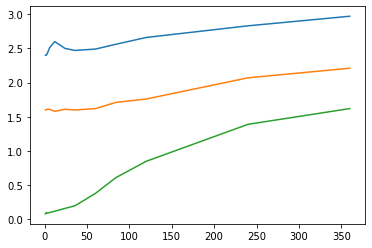

In [31]:
#plotting a quick example of some yield curves
time_lengths = [1, 2, 3, 6, 12, 24, 36, 60, 84, 120, 240, 360]
plt.plot(time_lengths, yield_comb.iloc[0])
plt.plot(time_lengths, yield_comb.iloc[225])
plt.plot(time_lengths, yield_comb.iloc[-1])

In [32]:
yield_comb['10yr2yr'] = yield_comb['10yr'] - yield_comb['2yr']
yield_comb['30yr5yr'] = yield_comb['30yr'] - yield_comb['5yr']
yield_comb.head()

,1mo,2mo,3mo,6mo,1yr,2yr,3yr,5yr,7yr,10yr,20yr,30yr,10yr2yr,30yr5yr
date,,,,,,,,,,,,,,
2019-01-02,2.40,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,2.83,2.97,0.16,0.48
2019-01-03,2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92,0.17,0.55
2019-01-04,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98,0.17,0.49
2019-01-07,2.42,2.42,2.45,2.54,2.58,2.53,2.51,2.53,2.60,2.70,2.86,2.99,0.17,0.46
2019-01-08,2.40,2.42,2.46,2.54,2.60,2.58,2.57,2.58,2.63,2.73,2.88,3.00,0.15,0.42


In [33]:
#Dropping dates that fall outside my data range
drop_dates = []
for x in yield_comb.index:
    if x > max(date_list):
        drop_dates.append(x)
    elif x < min(date_list):
        drop_dates.append(x)
yield_comb.drop(drop_dates, inplace=True)

In [34]:
#Adding yield columns to the sector_dates dataframe
#Creating sector_values dataframe, contains the data for ARIMA
sector_dates = sector_test.copy()
sector_dates['10yr2yr'] = 0
sector_dates['30yr5yr'] = 0
for x in sector_list:
    temp_frame = sector_dates.loc[x]
    for y in temp_frame.index:
        if y in yield_comb.index:
            sector_dates.loc[(x,y),'10yr2yr'] = yield_comb.loc[y, '10yr2yr']
            sector_dates.loc[(x,y),'30yr5yr'] = yield_comb.loc[y, '30yr5yr']
        else: 
            sector_dates.loc[(x,y),'10yr2yr'] = yield_comb.loc[prev, '10yr2yr']
            sector_dates.loc[(x,y),'30yr5yr'] = yield_comb.loc[prev, '30yr5yr']
        prev = y
sector_values = sector_test.drop(columns=['pct_change', 'intra_pct', 'delta_pct'])

# Data Visualization
(Most of this is at the end with the interface)

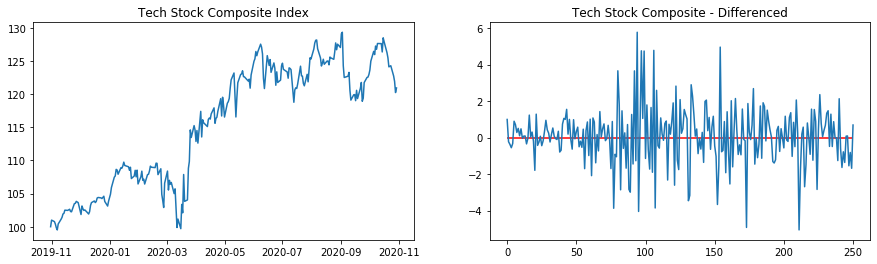

In [305]:
#Quick example of Box-Jenkins method, checking if data is stationary
tech_test = sector_values.loc['Technology']
tech_array = np.array(tech_test['sector_avg'])
tech_series = pd.Series(np.diff(tech_array))
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))
axes[0].plot(tech_test.index, tech_test['sector_avg'], '-')
axes[0].set(title='Tech Stock Composite Index')

# Differenced data
axes[1].plot(tech_series.index, tech_series, '-')
axes[1].hlines(0, 0, 250, 'r')
axes[1].set(title='Tech Stock Composite - Differenced');

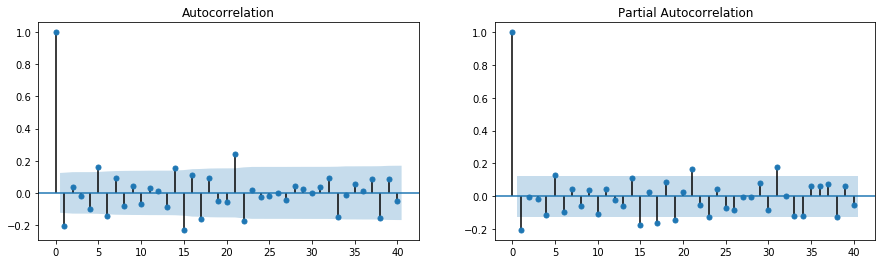

In [306]:
# Another example of Box-Jenkins, checking for AR
#Becomes zero at lag p+1 on Partial Autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(tech_series[1:], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(tech_series[1:], lags=40, ax=axes[1])

# Modeling - ARIMA

In [35]:
#Running all of the sector indices through auto_arima to find parameters
#Also returning all of the prediction results at the same time
order_dict = {}
results_dict = {}
pred_dict = {}
for x in sector_list:    
    temp_sector = sector_values.loc[x]
    temp_sector.index.freq=bday_us
    model = pm.auto_arima(temp_sector, max_p=8, max_d=4, max_q=8, seasonal=False, \
                          suppress_warnings=True, maxiter=200, error_action="ignore")
    model_dict = model.to_dict()
    order_dict[x] = [model_dict[y] for y in ['order','aic']]
    print(x +' = ARIMA {} : AIC Calculated = {}'.format(order_dict[x][0], order_dict[x][1]))
    
    results_dict[x] = model
    pred = model.predict_in_sample(start=180, return_conf_int=True)
    pred_vals = pred[0]
    pred_conf = pred[1]
    forecast = model.predict(5, return_conf_int=True)
    forecast_vals = forecast[0]
    forecast_conf = forecast[1]
    pred_dict[x] = [pred_vals, pred_conf, forecast_vals, forecast_conf]

Basic Industries = ARIMA (1, 1, 1) : AIC Calculated = 907.3227725538518
Capital Goods = ARIMA (1, 1, 1) : AIC Calculated = 908.2084706525967
Consumer Durables = ARIMA (0, 1, 1) : AIC Calculated = 924.1129944473238
Consumer Non-Durables = ARIMA (2, 1, 2) : AIC Calculated = 822.2465221229478
Consumer Services = ARIMA (2, 1, 2) : AIC Calculated = 871.245340112939
Energy = ARIMA (2, 1, 2) : AIC Calculated = 1001.8580297696692
Finance = ARIMA (0, 1, 1) : AIC Calculated = 936.2001969115777
Health Care = ARIMA (0, 1, 1) : AIC Calculated = 953.1109251511283
Miscellaneous = ARIMA (2, 1, 3) : AIC Calculated = 917.9058810107442
Public Utilities = ARIMA (0, 1, 0) : AIC Calculated = 832.6677642221832
Technology = ARIMA (1, 1, 0) : AIC Calculated = 927.4112511482426
Transportation = ARIMA (1, 1, 0) : AIC Calculated = 815.7548127933592


In [36]:
#Creating a dataframe from the prediction dictionary
#That was produced by the ARIMA outputs
pred_df = pd.DataFrame.from_dict(pred_dict, orient='index', \
                                 columns=['pred_vals', 'pred_conf', 'forecast_vals', 'forecast_conf'])
for x in sector_list:
    test_values = sector_values.loc[x][180:]
    sector_preds = pred_df.loc[x, 'pred_vals']
    print(x), return_rmse(test_values,sector_preds)

Basic Industries
The root mean squared error is 1.078.
Capital Goods
The root mean squared error is 1.092.
Consumer Durables
The root mean squared error is 1.142.
Consumer Non-Durables
The root mean squared error is 0.895.
Consumer Services
The root mean squared error is 1.003.
Energy
The root mean squared error is 1.333.
Finance
The root mean squared error is 1.062.
Health Care
The root mean squared error is 1.313.
Miscellaneous
The root mean squared error is 1.177.
Public Utilities
The root mean squared error is 0.755.
Technology
The root mean squared error is 1.333.
Transportation
The root mean squared error is 0.884.


In [37]:
#Creating a dataframe that is easier to access later
sectval_dict = {}
for x in sector_list:
    sectval_temp = sector_values.loc[x]
    sectval_dict[x] = sectval_temp['sector_avg']
sectval_df = pd.DataFrame(data=sectval_dict)
sectval_df.reset_index(inplace=True)
sectval_df.head()

,date,Basic Industries,Capital Goods,Consumer Durables,Consumer Non-Durables,Consumer Services,Energy,Finance,Health Care,Miscellaneous,Public Utilities,Technology,Transportation
0,2019-10-31,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2019-11-01,101.666739,101.275366,100.338850,100.464400,100.290714,101.805902,100.671028,101.329830,100.169585,100.154803,100.994993,101.137108
2,2019-11-04,101.809270,101.274496,100.327128,99.823490,100.138426,103.182333,100.714505,100.925657,100.129724,99.390808,100.770713,102.049915
3,2019-11-05,102.130015,101.263435,100.748291,99.857410,99.834400,102.658489,100.850102,100.348184,99.544895,98.767511,100.398887,102.377459
4,2019-11-06,102.281307,101.068357,100.415537,99.948731,99.673062,101.631083,100.930970,99.498252,99.472672,98.479397,99.844820,102.502214


In [38]:
#Running stocks through the ARIMA model based on their sector
stock_order_dict = {}
stock_results_dict = {}
stock_pred_dict = {}
for x in sector_list:    
    temp_sector = test_ind3[test_ind3['sector']==x]
    sect_order = order_dict[x][0]
    model = pm.ARIMA(order=sect_order, suppress_warnings=True)
    for y in temp_sector.index.get_level_values(0).unique():
        try:
            temp_stock = temp_sector.loc[y]
            temp_stock.index.freq=bday_us
            model.fit(temp_stock['close'])
            model_dict = model.to_dict()
            stock_order_dict[y] = [model_dict[z] for z in ['order','aic']]

            stock_results_dict[y] = model
            pred = model.predict_in_sample(start=180, return_conf_int=True)
            pred_vals = pred[0]
            pred_conf = pred[1]
            forecast = model.predict(5, return_conf_int=True)
            forecast_vals = forecast[0]
            forecast_conf = forecast[1]
            stock_pred_dict[y] = [pred_vals, pred_conf,\
                                  forecast_vals, forecast_conf]
        except:
            continue

In [39]:
#Creating a new dataframe that is easier to access later
stock_pred_df = pd.DataFrame.from_dict(stock_pred_dict, orient='index', \
                                 columns=['pred_vals', 'pred_conf',\
                                          'forecast_vals', 'forecast_conf'])
stockval_dict = {}
for x in test_ind3.index.get_level_values(0).unique():
    stockval_temp = test_ind3.loc[x]
    stockval_dict[x] = stockval_temp['close']
stockval_df = pd.DataFrame(data=stockval_dict)
stockval_df.reset_index(inplace=True)
stockval_df.head()

,date,A,AA,AAL,AAN,AAON,AAP,AAPL,AB,ABB,...,ZEN,ZG,ZI,ZION,ZLAB,ZM,ZNH,ZTO,ZTS,ZYME
0,2019-10-31,75.750000,20.790001,30.059999,74.930000,48.660000,162.479996,62.189999,29.360001,20.99,...,70.650002,32.389999,NaN,48.470001,33.790001,69.889999,30.930000,22.000000,127.919998,34.529999
1,2019-11-01,76.970001,21.870001,30.559999,74.010002,49.110001,164.820007,63.955002,29.059999,21.17,...,72.230003,33.619999,NaN,49.349998,35.590000,70.389999,31.070000,21.740000,125.339996,35.009998
2,2019-11-04,76.739998,22.910000,30.950001,73.870003,49.610001,166.610001,64.375000,29.180000,21.58,...,71.959999,33.860001,NaN,50.209999,35.980000,70.120003,32.779999,22.459999,124.760002,35.389999
3,2019-11-05,75.550003,22.590000,31.180000,65.459999,49.720001,168.139999,64.282501,29.540001,21.58,...,70.709999,33.290001,NaN,50.709999,36.790001,66.889999,33.590000,22.200001,120.250000,36.189999
4,2019-11-06,75.790001,21.900000,30.959999,62.320000,49.580002,169.699997,64.309998,29.620001,21.65,...,70.320000,33.610001,NaN,50.369999,36.980000,66.830002,33.320000,22.170000,121.470001,35.009998


# Modeling - LSTM

In [172]:
#Running the LSTM model on a random sample of stocks
random_samples = random.choices(test_ind3.index.get_level_values(0).unique(), k=100)
features = ['close', 'move_avg_7', 'intra_pct']
lstm_test = {}
ltsm_pred = {}
for x in random_samples:
    try:
        test_ind3_sub = test_ind3.loc[x][features]
        test_ind3_sub['move_avg_7'].replace(to_replace=0, method='bfill', inplace=True)
        training_set = test_ind3_sub[:date_list[220]].iloc[:,0:1].values
        test_set = test_ind3_sub[date_list[220]:].iloc[:,0:1].values
        sc = MinMaxScaler(feature_range=(0,1))
        training_set_scaled = sc.fit_transform(training_set)
        X_train = []
        y_train = []
        for i in range(60,220):
            X_train.append(training_set_scaled[i-60:i,0])
            y_train.append(training_set_scaled[i,0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
        # The LSTM architecture
        regressor = Sequential()
        # First LSTM layer with Dropout regularisation
        regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
        regressor.add(Dropout(0.5))
        # Second LSTM layer
        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(0.5))
        # Third LSTM layer
        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(0.5))
        # Fourth LSTM layer
        regressor.add(LSTM(units=50))
        regressor.add(Dropout(0.5))
        # The output layer
        regressor.add(Dense(units=1))
        # Compiling the RNN
        regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
        # Fitting to the training set
        regressor.fit(X_train,y_train,epochs=80,batch_size=32)
        dataset_total = pd.concat((test_ind3_sub['close'][:date_list[220]], \
                                   test_ind3_sub['close'][date_list[220]:]),axis=0)
        inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
        inputs = inputs.reshape(-1,1)
        inputs  = sc.transform(inputs)
        X_test = []
        for i in range(60,92):
            X_test.append(inputs[i-60:i,0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
        predicted_stock_price = regressor.predict(X_test)
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)
        lstm_test[x] = test_set
        ltsm_pred[x] = predicted_stock_price
    except:
        continue

Epoch 1/80
5/5 [==============================] - 1s 108ms/step - loss: 0.2160
Epoch 2/80
5/5 [==============================] - 1s 108ms/step - loss: 0.0732
Epoch 3/80
5/5 [==============================] - 1s 108ms/step - loss: 0.0636
Epoch 4/80
5/5 [==============================] - 1s 108ms/step - loss: 0.0461
Epoch 5/80
5/5 [==============================] - 1s 109ms/step - loss: 0.0681
Epoch 6/80
5/5 [==============================] - 1s 108ms/step - loss: 0.0525
Epoch 7/80
5/5 [==============================] - 1s 109ms/step - loss: 0.0434
Epoch 8/80
5/5 [==============================] - 1s 108ms/step - loss: 0.0515
Epoch 9/80
5/5 [==============================] - 1s 109ms/step - loss: 0.0617
Epoch 10/80
5/5 [==============================] - 1s 109ms/step - loss: 0.0435
Epoch 11/80
5/5 [==============================] - 1s 109ms/step - loss: 0.0465
Epoch 12/80
5/5 [==============================] - 1s 108ms/step - loss: 0.0427
Epoch 13/80
5/5 [==============================] 

5/5 [==============================] - 1s 113ms/step - loss: 0.0263
Epoch 15/80
5/5 [==============================] - 1s 112ms/step - loss: 0.0308
Epoch 16/80
5/5 [==============================] - 1s 111ms/step - loss: 0.0241
Epoch 17/80
5/5 [==============================] - 1s 111ms/step - loss: 0.0268
Epoch 18/80
5/5 [==============================] - 1s 111ms/step - loss: 0.0320
Epoch 19/80
5/5 [==============================] - 1s 111ms/step - loss: 0.0272
Epoch 20/80
5/5 [==============================] - 1s 111ms/step - loss: 0.0225
Epoch 21/80
5/5 [==============================] - 1s 112ms/step - loss: 0.0243
Epoch 22/80
5/5 [==============================] - 1s 112ms/step - loss: 0.0284
Epoch 23/80
5/5 [==============================] - 1s 112ms/step - loss: 0.0217
Epoch 24/80
5/5 [==============================] - 1s 112ms/step - loss: 0.0268
Epoch 25/80
5/5 [==============================] - 1s 112ms/step - loss: 0.0227
Epoch 26/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 118ms/step - loss: 0.0176
Epoch 28/80
5/5 [==============================] - 1s 119ms/step - loss: 0.0178
Epoch 29/80
5/5 [==============================] - 1s 117ms/step - loss: 0.0143
Epoch 30/80
5/5 [==============================] - 1s 116ms/step - loss: 0.0191
Epoch 31/80
5/5 [==============================] - 1s 116ms/step - loss: 0.0194
Epoch 32/80
5/5 [==============================] - 1s 118ms/step - loss: 0.0178
Epoch 33/80
5/5 [==============================] - 1s 118ms/step - loss: 0.0189
Epoch 34/80
5/5 [==============================] - 1s 117ms/step - loss: 0.0188
Epoch 35/80
5/5 [==============================] - 1s 119ms/step - loss: 0.0178
Epoch 36/80
5/5 [==============================] - 1s 116ms/step - loss: 0.0157
Epoch 37/80
5/5 [==============================] - 1s 118ms/step - loss: 0.0193
Epoch 38/80
5/5 [==============================] - 1s 118ms/step - loss: 0.0159
Epoch 39/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 117ms/step - loss: 0.0356
Epoch 41/80
5/5 [==============================] - 1s 116ms/step - loss: 0.0285
Epoch 42/80
5/5 [==============================] - 1s 118ms/step - loss: 0.0363
Epoch 43/80
5/5 [==============================] - 1s 116ms/step - loss: 0.0343
Epoch 44/80
5/5 [==============================] - 1s 117ms/step - loss: 0.0338
Epoch 45/80
5/5 [==============================] - 1s 116ms/step - loss: 0.0276
Epoch 46/80
5/5 [==============================] - 1s 117ms/step - loss: 0.0438
Epoch 47/80
5/5 [==============================] - 1s 116ms/step - loss: 0.0327
Epoch 48/80
5/5 [==============================] - 1s 116ms/step - loss: 0.0346
Epoch 49/80
5/5 [==============================] - 1s 117ms/step - loss: 0.0301
Epoch 50/80
5/5 [==============================] - 1s 115ms/step - loss: 0.0319
Epoch 51/80
5/5 [==============================] - 1s 117ms/step - loss: 0.0370
Epoch 52/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 120ms/step - loss: 0.0213
Epoch 54/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0192
Epoch 55/80
5/5 [==============================] - 1s 119ms/step - loss: 0.0303
Epoch 56/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0319
Epoch 57/80
5/5 [==============================] - 1s 119ms/step - loss: 0.0227
Epoch 58/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0265
Epoch 59/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0211
Epoch 60/80
5/5 [==============================] - 1s 119ms/step - loss: 0.0227
Epoch 61/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0246
Epoch 62/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0207
Epoch 63/80
5/5 [==============================] - 1s 119ms/step - loss: 0.0223
Epoch 64/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0227
Epoch 65/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 121ms/step - loss: 0.0107
Epoch 67/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0163
Epoch 68/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0146
Epoch 69/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0131
Epoch 70/80
5/5 [==============================] - 1s 121ms/step - loss: 0.0193
Epoch 71/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0132
Epoch 72/80
5/5 [==============================] - 1s 121ms/step - loss: 0.0155
Epoch 73/80
5/5 [==============================] - 1s 121ms/step - loss: 0.0128
Epoch 74/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0139
Epoch 75/80
5/5 [==============================] - 1s 120ms/step - loss: 0.0191
Epoch 76/80
5/5 [==============================] - 1s 122ms/step - loss: 0.0127
Epoch 77/80
5/5 [==============================] - 1s 121ms/step - loss: 0.0184
Epoch 78/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 121ms/step - loss: 0.0078
Epoch 80/80
5/5 [==============================] - 1s 122ms/step - loss: 0.0085
Epoch 1/80
5/5 [==============================] - 1s 121ms/step - loss: 0.1591
Epoch 2/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0464
Epoch 3/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0439
Epoch 4/80
5/5 [==============================] - 1s 123ms/step - loss: 0.0396
Epoch 5/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0455
Epoch 6/80
5/5 [==============================] - 1s 121ms/step - loss: 0.0352
Epoch 7/80
5/5 [==============================] - 1s 122ms/step - loss: 0.0405
Epoch 8/80
5/5 [==============================] - 1s 123ms/step - loss: 0.0373
Epoch 9/80
5/5 [==============================] - 1s 122ms/step - loss: 0.0340
Epoch 10/80
5/5 [==============================] - 1s 121ms/step - loss: 0.0405
Epoch 11/80
5/5 [==============================] - 1s 123ms/s

5/5 [==============================] - 1s 124ms/step - loss: 0.0527
Epoch 3/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0541
Epoch 4/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0631
Epoch 5/80
5/5 [==============================] - 1s 123ms/step - loss: 0.0459
Epoch 6/80
5/5 [==============================] - 1s 127ms/step - loss: 0.0467
Epoch 7/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0434
Epoch 8/80
5/5 [==============================] - 1s 123ms/step - loss: 0.0506
Epoch 9/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0542
Epoch 10/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0455
Epoch 11/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0351
Epoch 12/80
5/5 [==============================] - 1s 126ms/step - loss: 0.0457
Epoch 13/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0311
Epoch 14/80
5/5 [==============================] - 1s 130ms

5/5 [==============================] - 1s 123ms/step - loss: 0.0266
Epoch 16/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0283
Epoch 17/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0268
Epoch 18/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0293
Epoch 19/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0235
Epoch 20/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0281
Epoch 21/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0236
Epoch 22/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0206
Epoch 23/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0243
Epoch 24/80
5/5 [==============================] - 1s 124ms/step - loss: 0.0238
Epoch 25/80
5/5 [==============================] - 1s 126ms/step - loss: 0.0268
Epoch 26/80
5/5 [==============================] - 1s 127ms/step - loss: 0.0223
Epoch 27/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 129ms/step - loss: 0.0298
Epoch 29/80
5/5 [==============================] - 1s 131ms/step - loss: 0.0234
Epoch 30/80
5/5 [==============================] - 1s 131ms/step - loss: 0.0138
Epoch 31/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0263
Epoch 32/80
5/5 [==============================] - 1s 130ms/step - loss: 0.0159
Epoch 33/80
5/5 [==============================] - 1s 131ms/step - loss: 0.0202
Epoch 34/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0221
Epoch 35/80
5/5 [==============================] - 1s 131ms/step - loss: 0.0211
Epoch 36/80
5/5 [==============================] - 1s 132ms/step - loss: 0.0174
Epoch 37/80
5/5 [==============================] - 1s 132ms/step - loss: 0.0199
Epoch 38/80
5/5 [==============================] - 1s 131ms/step - loss: 0.0143
Epoch 39/80
5/5 [==============================] - 1s 132ms/step - loss: 0.0204
Epoch 40/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 129ms/step - loss: 0.0210
Epoch 42/80
5/5 [==============================] - 1s 132ms/step - loss: 0.0254
Epoch 43/80
5/5 [==============================] - 1s 130ms/step - loss: 0.0264
Epoch 44/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0227
Epoch 45/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0229
Epoch 46/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0270
Epoch 47/80
5/5 [==============================] - 1s 130ms/step - loss: 0.0211
Epoch 48/80
5/5 [==============================] - 1s 130ms/step - loss: 0.0231
Epoch 49/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0253
Epoch 50/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0192
Epoch 51/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0217
Epoch 52/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0189
Epoch 53/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 126ms/step - loss: 0.0114
Epoch 55/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0135
Epoch 56/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0139
Epoch 57/80
5/5 [==============================] - 1s 126ms/step - loss: 0.0113
Epoch 58/80
5/5 [==============================] - 1s 126ms/step - loss: 0.0118
Epoch 59/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0142
Epoch 60/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0145
Epoch 61/80
5/5 [==============================] - 1s 125ms/step - loss: 0.0172
Epoch 62/80
5/5 [==============================] - 1s 126ms/step - loss: 0.0121
Epoch 63/80
5/5 [==============================] - 1s 127ms/step - loss: 0.0120
Epoch 64/80
5/5 [==============================] - 1s 126ms/step - loss: 0.0105
Epoch 65/80
5/5 [==============================] - 1s 126ms/step - loss: 0.0104
Epoch 66/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 128ms/step - loss: 0.0190
Epoch 68/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0259
Epoch 69/80
5/5 [==============================] - 1s 127ms/step - loss: 0.0180
Epoch 70/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0214
Epoch 71/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0190
Epoch 72/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0177
Epoch 73/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0171
Epoch 74/80
5/5 [==============================] - 1s 127ms/step - loss: 0.0235
Epoch 75/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0178
Epoch 76/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0194
Epoch 77/80
5/5 [==============================] - 1s 129ms/step - loss: 0.0182
Epoch 78/80
5/5 [==============================] - 1s 128ms/step - loss: 0.0247
Epoch 79/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 131ms/step - loss: 0.0140
Epoch 1/80
5/5 [==============================] - 1s 133ms/step - loss: 0.1015
Epoch 2/80
5/5 [==============================] - 1s 137ms/step - loss: 0.0508
Epoch 3/80
5/5 [==============================] - 1s 133ms/step - loss: 0.0552
Epoch 4/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0480
Epoch 5/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0394
Epoch 6/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0511
Epoch 7/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0468
Epoch 8/80
5/5 [==============================] - 1s 136ms/step - loss: 0.0261
Epoch 9/80
5/5 [==============================] - 1s 135ms/step - loss: 0.0279
Epoch 10/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0298
Epoch 11/80
5/5 [==============================] - 1s 135ms/step - loss: 0.0359
Epoch 12/80
5/5 [==============================] - 1s 134ms/s

5/5 [==============================] - 1s 133ms/step - loss: 0.0416
Epoch 4/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0386
Epoch 5/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0405
Epoch 6/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0371
Epoch 7/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0280
Epoch 8/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0455
Epoch 9/80
5/5 [==============================] - 1s 133ms/step - loss: 0.0263
Epoch 10/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0425
Epoch 11/80
5/5 [==============================] - 1s 133ms/step - loss: 0.0277
Epoch 12/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0274
Epoch 13/80
5/5 [==============================] - 1s 134ms/step - loss: 0.0263
Epoch 14/80
5/5 [==============================] - 1s 132ms/step - loss: 0.0227
Epoch 15/80
5/5 [==============================] - 1s 134m

5/5 [==============================] - 1s 136ms/step - loss: 0.0172
Epoch 17/80
5/5 [==============================] - 1s 137ms/step - loss: 0.0121
Epoch 18/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0118
Epoch 19/80
5/5 [==============================] - 1s 137ms/step - loss: 0.0122
Epoch 20/80
5/5 [==============================] - 1s 136ms/step - loss: 0.0188
Epoch 21/80
5/5 [==============================] - 1s 137ms/step - loss: 0.0129
Epoch 22/80
5/5 [==============================] - 1s 139ms/step - loss: 0.0130
Epoch 23/80
5/5 [==============================] - 1s 137ms/step - loss: 0.0129
Epoch 24/80
5/5 [==============================] - 1s 137ms/step - loss: 0.0159
Epoch 25/80
5/5 [==============================] - 1s 137ms/step - loss: 0.0119
Epoch 26/80
5/5 [==============================] - 1s 137ms/step - loss: 0.0139
Epoch 27/80
5/5 [==============================] - 1s 136ms/step - loss: 0.0116
Epoch 28/80
5/5 [==============================] - 1

Epoch 29/80
5/5 [==============================] - 1s 141ms/step - loss: 0.0339
Epoch 30/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0292
Epoch 31/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0392
Epoch 32/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0426
Epoch 33/80
5/5 [==============================] - 1s 139ms/step - loss: 0.0429
Epoch 34/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0379
Epoch 35/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0399
Epoch 36/80
5/5 [==============================] - 1s 140ms/step - loss: 0.0357
Epoch 37/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0403
Epoch 38/80
5/5 [==============================] - 1s 140ms/step - loss: 0.0340
Epoch 39/80
5/5 [==============================] - 1s 139ms/step - loss: 0.0333
Epoch 40/80
5/5 [==============================] - 1s 139ms/step - loss: 0.0303
Epoch 41/80
5/5 [=======================

Epoch 42/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0219
Epoch 43/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0201
Epoch 44/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0215
Epoch 45/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0187
Epoch 46/80
5/5 [==============================] - 1s 139ms/step - loss: 0.0176
Epoch 47/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0199
Epoch 48/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0166
Epoch 49/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0183
Epoch 50/80
5/5 [==============================] - 1s 137ms/step - loss: 0.0175
Epoch 51/80
5/5 [==============================] - 1s 139ms/step - loss: 0.0175
Epoch 52/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0197
Epoch 53/80
5/5 [==============================] - 1s 138ms/step - loss: 0.0197
Epoch 54/80
5/5 [=======================

5/5 [==============================] - 1s 144ms/step - loss: 0.0250
Epoch 55/80
5/5 [==============================] - 1s 142ms/step - loss: 0.0208
Epoch 56/80
5/5 [==============================] - 1s 144ms/step - loss: 0.0259
Epoch 57/80
5/5 [==============================] - 1s 141ms/step - loss: 0.0201
Epoch 58/80
5/5 [==============================] - 1s 143ms/step - loss: 0.0173
Epoch 59/80
5/5 [==============================] - 1s 143ms/step - loss: 0.0201
Epoch 60/80
5/5 [==============================] - 1s 145ms/step - loss: 0.0190
Epoch 61/80
5/5 [==============================] - 1s 143ms/step - loss: 0.0164
Epoch 62/80
5/5 [==============================] - 1s 143ms/step - loss: 0.0192
Epoch 63/80
5/5 [==============================] - 1s 144ms/step - loss: 0.0187
Epoch 64/80
5/5 [==============================] - 1s 143ms/step - loss: 0.0181
Epoch 65/80
5/5 [==============================] - 1s 143ms/step - loss: 0.0158
Epoch 66/80
5/5 [==============================] - 1

Epoch 67/80
5/5 [==============================] - 1s 145ms/step - loss: 0.0128
Epoch 68/80
5/5 [==============================] - 1s 144ms/step - loss: 0.0122
Epoch 69/80
5/5 [==============================] - 1s 144ms/step - loss: 0.0139
Epoch 70/80
5/5 [==============================] - 1s 145ms/step - loss: 0.0109
Epoch 71/80
5/5 [==============================] - 1s 144ms/step - loss: 0.0136
Epoch 72/80
5/5 [==============================] - 1s 145ms/step - loss: 0.0109
Epoch 73/80
5/5 [==============================] - 1s 145ms/step - loss: 0.0109
Epoch 74/80
5/5 [==============================] - 1s 145ms/step - loss: 0.0132
Epoch 75/80
5/5 [==============================] - 1s 145ms/step - loss: 0.0107
Epoch 76/80
5/5 [==============================] - 1s 146ms/step - loss: 0.0123
Epoch 77/80
5/5 [==============================] - 1s 145ms/step - loss: 0.0142
Epoch 78/80
5/5 [==============================] - 1s 146ms/step - loss: 0.0125
Epoch 79/80
5/5 [=======================

5/5 [==============================] - 1s 147ms/step - loss: 0.0130
Epoch 80/80
5/5 [==============================] - 1s 147ms/step - loss: 0.0133
Epoch 1/80
5/5 [==============================] - 1s 147ms/step - loss: 0.0891
Epoch 2/80
5/5 [==============================] - 1s 148ms/step - loss: 0.0312
Epoch 3/80
5/5 [==============================] - 1s 148ms/step - loss: 0.0367
Epoch 4/80
5/5 [==============================] - 1s 148ms/step - loss: 0.0357
Epoch 5/80
5/5 [==============================] - 1s 149ms/step - loss: 0.0317
Epoch 6/80
5/5 [==============================] - 1s 148ms/step - loss: 0.0270
Epoch 7/80
5/5 [==============================] - 1s 149ms/step - loss: 0.0250
Epoch 8/80
5/5 [==============================] - 1s 149ms/step - loss: 0.0348
Epoch 9/80
5/5 [==============================] - 1s 148ms/step - loss: 0.0308
Epoch 10/80
5/5 [==============================] - 1s 148ms/step - loss: 0.0216
Epoch 11/80
5/5 [==============================] - 1s 148ms/s

5/5 [==============================] - 1s 150ms/step - loss: 0.0420
Epoch 3/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0606
Epoch 4/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0383
Epoch 5/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0426
Epoch 6/80
5/5 [==============================] - 1s 150ms/step - loss: 0.0298
Epoch 7/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0462
Epoch 8/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0330
Epoch 9/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0417
Epoch 10/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0258
Epoch 11/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0489
Epoch 12/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0304
Epoch 13/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0328
Epoch 14/80
5/5 [==============================] - 1s 152ms

5/5 [==============================] - 1s 150ms/step - loss: 0.0208
Epoch 15/80
5/5 [==============================] - 1s 149ms/step - loss: 0.0148
Epoch 16/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0189
Epoch 17/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0155
Epoch 18/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0203
Epoch 19/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0156
Epoch 20/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0153
Epoch 21/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0149
Epoch 22/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0171
Epoch 23/80
5/5 [==============================] - 1s 150ms/step - loss: 0.0135
Epoch 24/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0172
Epoch 25/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0197
Epoch 26/80
5/5 [==============================] - 1

Epoch 27/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0224
Epoch 28/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0251
Epoch 29/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0197
Epoch 30/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0153
Epoch 31/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0152
Epoch 32/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0207
Epoch 33/80
5/5 [==============================] - 1s 154ms/step - loss: 0.0223
Epoch 34/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0134
Epoch 35/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0169
Epoch 36/80
5/5 [==============================] - 1s 151ms/step - loss: 0.0189
Epoch 37/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0193
Epoch 38/80
5/5 [==============================] - 1s 152ms/step - loss: 0.0229
Epoch 39/80
5/5 [=======================

Epoch 40/80
5/5 [==============================] - 1s 153ms/step - loss: 0.0280
Epoch 41/80
5/5 [==============================] - 1s 154ms/step - loss: 0.0230
Epoch 42/80
5/5 [==============================] - 1s 154ms/step - loss: 0.0261
Epoch 43/80
5/5 [==============================] - 1s 155ms/step - loss: 0.0293
Epoch 44/80
5/5 [==============================] - 1s 154ms/step - loss: 0.0298
Epoch 45/80
5/5 [==============================] - 1s 156ms/step - loss: 0.0239
Epoch 46/80
5/5 [==============================] - 1s 153ms/step - loss: 0.0189
Epoch 47/80
5/5 [==============================] - 1s 154ms/step - loss: 0.0272
Epoch 48/80
5/5 [==============================] - 1s 153ms/step - loss: 0.0256
Epoch 49/80
5/5 [==============================] - 1s 157ms/step - loss: 0.0259
Epoch 50/80
5/5 [==============================] - 1s 154ms/step - loss: 0.0313
Epoch 51/80
5/5 [==============================] - 1s 154ms/step - loss: 0.0211
Epoch 52/80
5/5 [=======================

Epoch 53/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0155
Epoch 54/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0149
Epoch 55/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0157
Epoch 56/80
5/5 [==============================] - 1s 160ms/step - loss: 0.0135
Epoch 57/80
5/5 [==============================] - 1s 159ms/step - loss: 0.0141
Epoch 58/80
5/5 [==============================] - 1s 159ms/step - loss: 0.0138
Epoch 59/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0159
Epoch 60/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0096
Epoch 61/80
5/5 [==============================] - 1s 160ms/step - loss: 0.0142
Epoch 62/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0167
Epoch 63/80
5/5 [==============================] - 1s 159ms/step - loss: 0.0138
Epoch 64/80
5/5 [==============================] - 1s 159ms/step - loss: 0.0147
Epoch 65/80
5/5 [=======================

Epoch 66/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0159
Epoch 67/80
5/5 [==============================] - 1s 162ms/step - loss: 0.0149
Epoch 68/80
5/5 [==============================] - 1s 159ms/step - loss: 0.0181
Epoch 69/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0148
Epoch 70/80
5/5 [==============================] - 1s 160ms/step - loss: 0.0153
Epoch 71/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0169
Epoch 72/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0198
Epoch 73/80
5/5 [==============================] - 1s 163ms/step - loss: 0.0175 0s - loss: 0.01
Epoch 74/80
5/5 [==============================] - 1s 160ms/step - loss: 0.0226
Epoch 75/80
5/5 [==============================] - 1s 160ms/step - loss: 0.0144
Epoch 76/80
5/5 [==============================] - 1s 160ms/step - loss: 0.0149
Epoch 77/80
5/5 [==============================] - 1s 161ms/step - loss: 0.0140
Epoch 78/80
5/5 [=======

5/5 [==============================] - 1s 165ms/step - loss: 0.0116
Epoch 79/80
5/5 [==============================] - 1s 163ms/step - loss: 0.0144
Epoch 80/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0116
Epoch 1/80
5/5 [==============================] - 1s 164ms/step - loss: 0.1355
Epoch 2/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0739
Epoch 3/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0513
Epoch 4/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0415
Epoch 5/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0345
Epoch 6/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0232
Epoch 7/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0323
Epoch 8/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0364
Epoch 9/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0497
Epoch 10/80
5/5 [==============================] - 1s 164ms/s

5/5 [==============================] - 1s 164ms/step - loss: 0.2177
Epoch 2/80
5/5 [==============================] - 1s 167ms/step - loss: 0.0799
Epoch 3/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0652
Epoch 4/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0686
Epoch 5/80
5/5 [==============================] - 1s 168ms/step - loss: 0.0555
Epoch 6/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0496
Epoch 7/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0639
Epoch 8/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0454
Epoch 9/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0308
Epoch 10/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0565
Epoch 11/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0313
Epoch 12/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0251
Epoch 13/80
5/5 [==============================] - 1s 165ms/

5/5 [==============================] - 1s 167ms/step - loss: 0.0584
Epoch 15/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0429
Epoch 16/80
5/5 [==============================] - 1s 167ms/step - loss: 0.0428
Epoch 17/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0360
Epoch 18/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0635
Epoch 19/80
5/5 [==============================] - 1s 168ms/step - loss: 0.0558
Epoch 20/80
5/5 [==============================] - 1s 167ms/step - loss: 0.0378
Epoch 21/80
5/5 [==============================] - 1s 167ms/step - loss: 0.0401
Epoch 22/80
5/5 [==============================] - 1s 167ms/step - loss: 0.0431
Epoch 23/80
5/5 [==============================] - 1s 167ms/step - loss: 0.0463
Epoch 24/80
5/5 [==============================] - 1s 167ms/step - loss: 0.0507
Epoch 25/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0408
Epoch 26/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 166ms/step - loss: 0.0326
Epoch 28/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0348
Epoch 29/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0371
Epoch 30/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0384
Epoch 31/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0362
Epoch 32/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0395
Epoch 33/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0257
Epoch 34/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0293
Epoch 35/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0401
Epoch 36/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0299
Epoch 37/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0377
Epoch 38/80
5/5 [==============================] - 1s 170ms/step - loss: 0.0301
Epoch 39/80
5/5 [==============================] - 1

Epoch 40/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0204
Epoch 41/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0272
Epoch 42/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0204
Epoch 43/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0222
Epoch 44/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0220
Epoch 45/80
5/5 [==============================] - 1s 167ms/step - loss: 0.0255
Epoch 46/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0212
Epoch 47/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0247
Epoch 48/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0258
Epoch 49/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0228
Epoch 50/80
5/5 [==============================] - 1s 166ms/step - loss: 0.0207
Epoch 51/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0237
Epoch 52/80
5/5 [=======================

Epoch 53/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0098
Epoch 54/80
5/5 [==============================] - 1s 167ms/step - loss: 0.0138
Epoch 55/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0145
Epoch 56/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0101
Epoch 57/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0134
Epoch 58/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0193
Epoch 59/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0104
Epoch 60/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0149
Epoch 61/80
5/5 [==============================] - 1s 163ms/step - loss: 0.0128
Epoch 62/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0179
Epoch 63/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0119
Epoch 64/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0131
Epoch 65/80
5/5 [=======================

Epoch 66/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0184
Epoch 67/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0182
Epoch 68/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0226
Epoch 69/80
5/5 [==============================] - 1s 163ms/step - loss: 0.0171
Epoch 70/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0200
Epoch 71/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0238
Epoch 72/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0177
Epoch 73/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0154
Epoch 74/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0199
Epoch 75/80
5/5 [==============================] - 1s 165ms/step - loss: 0.0154
Epoch 76/80
5/5 [==============================] - 1s 164ms/step - loss: 0.0231
Epoch 77/80
5/5 [==============================] - 1s 168ms/step - loss: 0.0171
Epoch 78/80
5/5 [=======================

Epoch 79/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0205
Epoch 80/80
5/5 [==============================] - 1s 168ms/step - loss: 0.0240
Epoch 1/80
5/5 [==============================] - 1s 166ms/step - loss: 0.1982
Epoch 2/80
5/5 [==============================] - 1s 170ms/step - loss: 0.0556
Epoch 3/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0500
Epoch 4/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0542
Epoch 5/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0435
Epoch 6/80
5/5 [==============================] - 1s 168ms/step - loss: 0.0547
Epoch 7/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0420
Epoch 8/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0406
Epoch 9/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0559
Epoch 10/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0491
Epoch 11/80
5/5 [==============================] 

5/5 [==============================] - 1s 169ms/step - loss: 0.0400
Epoch 3/80
5/5 [==============================] - 1s 168ms/step - loss: 0.0364
Epoch 4/80
5/5 [==============================] - 1s 170ms/step - loss: 0.0295
Epoch 5/80
5/5 [==============================] - 1s 170ms/step - loss: 0.0297
Epoch 6/80
5/5 [==============================] - 1s 170ms/step - loss: 0.0341
Epoch 7/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0262
Epoch 8/80
5/5 [==============================] - 1s 168ms/step - loss: 0.0251
Epoch 9/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0340
Epoch 10/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0247
Epoch 11/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0315
Epoch 12/80
5/5 [==============================] - 1s 168ms/step - loss: 0.0223
Epoch 13/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0274
Epoch 14/80
5/5 [==============================] - 1s 169ms

5/5 [==============================] - 1s 170ms/step - loss: 0.0228
Epoch 16/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0184
Epoch 17/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0283
Epoch 18/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0297
Epoch 19/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0225
Epoch 20/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0226
Epoch 21/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0223
Epoch 22/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0232
Epoch 23/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0290
Epoch 24/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0235
Epoch 25/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0182
Epoch 26/80
5/5 [==============================] - 1s 169ms/step - loss: 0.0188
Epoch 27/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 172ms/step - loss: 0.0209
Epoch 29/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0214
Epoch 30/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0178
Epoch 31/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0202
Epoch 32/80
5/5 [==============================] - 1s 173ms/step - loss: 0.0198
Epoch 33/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0191
Epoch 34/80
5/5 [==============================] - 1s 174ms/step - loss: 0.0178
Epoch 35/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0235
Epoch 36/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0201
Epoch 37/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0167
Epoch 38/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0202
Epoch 39/80
5/5 [==============================] - 1s 173ms/step - loss: 0.0198
Epoch 40/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 172ms/step - loss: 0.0204
Epoch 42/80
5/5 [==============================] - 1s 173ms/step - loss: 0.0194
Epoch 43/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0165
Epoch 44/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0207
Epoch 45/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0161
Epoch 46/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0187
Epoch 47/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0208
Epoch 48/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0175
Epoch 49/80
5/5 [==============================] - 1s 171ms/step - loss: 0.0200
Epoch 50/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0201
Epoch 51/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0167
Epoch 52/80
5/5 [==============================] - 1s 172ms/step - loss: 0.0162
Epoch 53/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 178ms/step - loss: 0.0313
Epoch 55/80
5/5 [==============================] - 1s 175ms/step - loss: 0.0347
Epoch 56/80
5/5 [==============================] - 1s 177ms/step - loss: 0.0254
Epoch 57/80
5/5 [==============================] - 1s 181ms/step - loss: 0.0299
Epoch 58/80
5/5 [==============================] - 1s 177ms/step - loss: 0.0296
Epoch 59/80
5/5 [==============================] - 1s 178ms/step - loss: 0.0274
Epoch 60/80
5/5 [==============================] - 1s 176ms/step - loss: 0.0345
Epoch 61/80
5/5 [==============================] - 1s 176ms/step - loss: 0.0304
Epoch 62/80
5/5 [==============================] - 1s 177ms/step - loss: 0.0378
Epoch 63/80
5/5 [==============================] - 1s 178ms/step - loss: 0.0297
Epoch 64/80
5/5 [==============================] - 1s 178ms/step - loss: 0.0334
Epoch 65/80
5/5 [==============================] - 1s 177ms/step - loss: 0.0308
Epoch 66/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 178ms/step - loss: 0.0113
Epoch 68/80
5/5 [==============================] - 1s 180ms/step - loss: 0.0117
Epoch 69/80
5/5 [==============================] - 1s 179ms/step - loss: 0.0105
Epoch 70/80
5/5 [==============================] - 1s 179ms/step - loss: 0.0122
Epoch 71/80
5/5 [==============================] - 1s 179ms/step - loss: 0.0102
Epoch 72/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0147
Epoch 73/80
5/5 [==============================] - 1s 178ms/step - loss: 0.0094
Epoch 74/80
5/5 [==============================] - 1s 179ms/step - loss: 0.0108
Epoch 75/80
5/5 [==============================] - 1s 179ms/step - loss: 0.0135
Epoch 76/80
5/5 [==============================] - 1s 180ms/step - loss: 0.0115
Epoch 77/80
5/5 [==============================] - 1s 179ms/step - loss: 0.0096
Epoch 78/80
5/5 [==============================] - 1s 180ms/step - loss: 0.0120
Epoch 79/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 181ms/step - loss: 0.0199
Epoch 1/80
5/5 [==============================] - 1s 183ms/step - loss: 0.1388
Epoch 2/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0691
Epoch 3/80
5/5 [==============================] - 1s 186ms/step - loss: 0.0423
Epoch 4/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0468
Epoch 5/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0535
Epoch 6/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0356
Epoch 7/80
5/5 [==============================] - 1s 181ms/step - loss: 0.0525
Epoch 8/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0420
Epoch 9/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0452
Epoch 10/80
5/5 [==============================] - 1s 185ms/step - loss: 0.0400
Epoch 11/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0353
Epoch 12/80
5/5 [==============================] - 1s 182ms/s

5/5 [==============================] - 1s 185ms/step - loss: 0.0548
Epoch 4/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0477
Epoch 5/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0424
Epoch 6/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0606
Epoch 7/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0412
Epoch 8/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0483
Epoch 9/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0466
Epoch 10/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0593
Epoch 11/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0520
Epoch 12/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0357
Epoch 13/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0439
Epoch 14/80
5/5 [==============================] - 1s 185ms/step - loss: 0.0447
Epoch 15/80
5/5 [==============================] - 1s 183m

5/5 [==============================] - 1s 185ms/step - loss: 0.0309
Epoch 17/80
5/5 [==============================] - 1s 186ms/step - loss: 0.0201
Epoch 18/80
5/5 [==============================] - 1s 189ms/step - loss: 0.0197
Epoch 19/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0252
Epoch 20/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0174
Epoch 21/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0179
Epoch 22/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0174
Epoch 23/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0245
Epoch 24/80
5/5 [==============================] - 1s 181ms/step - loss: 0.0157
Epoch 25/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0128
Epoch 26/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0194
Epoch 27/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0166
Epoch 28/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 183ms/step - loss: 0.0241
Epoch 30/80
5/5 [==============================] - 1s 185ms/step - loss: 0.0261
Epoch 31/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0301
Epoch 32/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0280
Epoch 33/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0222
Epoch 34/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0211
Epoch 35/80
5/5 [==============================] - 1s 181ms/step - loss: 0.0203
Epoch 36/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0250
Epoch 37/80
5/5 [==============================] - 1s 187ms/step - loss: 0.0229
Epoch 38/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0304
Epoch 39/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0204
Epoch 40/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0200
Epoch 41/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 183ms/step - loss: 0.0239
Epoch 43/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0225
Epoch 44/80
5/5 [==============================] - 1s 184ms/step - loss: 0.0295
Epoch 45/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0285
Epoch 46/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0220
Epoch 47/80
5/5 [==============================] - 1s 181ms/step - loss: 0.0222
Epoch 48/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0211
Epoch 49/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0234
Epoch 50/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0253
Epoch 51/80
5/5 [==============================] - 1s 181ms/step - loss: 0.0250
Epoch 52/80
5/5 [==============================] - 1s 183ms/step - loss: 0.0204
Epoch 53/80
5/5 [==============================] - 1s 182ms/step - loss: 0.0229
Epoch 54/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 196ms/step - loss: 0.0181
Epoch 56/80
5/5 [==============================] - 1s 193ms/step - loss: 0.0204
Epoch 57/80
5/5 [==============================] - 1s 192ms/step - loss: 0.0201
Epoch 58/80
5/5 [==============================] - 1s 192ms/step - loss: 0.0255
Epoch 59/80
5/5 [==============================] - 1s 195ms/step - loss: 0.0162
Epoch 60/80
5/5 [==============================] - 1s 192ms/step - loss: 0.0213
Epoch 61/80
5/5 [==============================] - 1s 196ms/step - loss: 0.0129
Epoch 62/80
5/5 [==============================] - 1s 198ms/step - loss: 0.0169
Epoch 63/80
5/5 [==============================] - 1s 193ms/step - loss: 0.0239
Epoch 64/80
5/5 [==============================] - 1s 194ms/step - loss: 0.0158
Epoch 65/80
5/5 [==============================] - 1s 193ms/step - loss: 0.0143
Epoch 66/80
5/5 [==============================] - 1s 195ms/step - loss: 0.0214
Epoch 67/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 194ms/step - loss: 0.0196
Epoch 69/80
5/5 [==============================] - 1s 193ms/step - loss: 0.0179
Epoch 70/80
5/5 [==============================] - 1s 197ms/step - loss: 0.0147
Epoch 71/80
5/5 [==============================] - 1s 194ms/step - loss: 0.0163
Epoch 72/80
5/5 [==============================] - 1s 194ms/step - loss: 0.0108
Epoch 73/80
5/5 [==============================] - 1s 193ms/step - loss: 0.0207
Epoch 74/80
5/5 [==============================] - 1s 193ms/step - loss: 0.0099
Epoch 75/80
5/5 [==============================] - 1s 197ms/step - loss: 0.0146
Epoch 76/80
5/5 [==============================] - 1s 195ms/step - loss: 0.0181
Epoch 77/80
5/5 [==============================] - 1s 196ms/step - loss: 0.0147
Epoch 78/80
5/5 [==============================] - 1s 194ms/step - loss: 0.0124
Epoch 79/80
5/5 [==============================] - 1s 195ms/step - loss: 0.0119
Epoch 80/80
5/5 [==============================] - 1

Epoch 1/80
5/5 [==============================] - 1s 197ms/step - loss: 0.0860
Epoch 2/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0330
Epoch 3/80
5/5 [==============================] - 1s 196ms/step - loss: 0.0312
Epoch 4/80
5/5 [==============================] - 1s 197ms/step - loss: 0.0315
Epoch 5/80
5/5 [==============================] - 1s 197ms/step - loss: 0.0298
Epoch 6/80
5/5 [==============================] - 1s 198ms/step - loss: 0.0341
Epoch 7/80
5/5 [==============================] - 1s 198ms/step - loss: 0.0276
Epoch 8/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0267
Epoch 9/80
5/5 [==============================] - 1s 198ms/step - loss: 0.0368
Epoch 10/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0347
Epoch 11/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0263
Epoch 12/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0234
Epoch 13/80
5/5 [==============================] 

5/5 [==============================] - 1s 199ms/step - loss: 0.0351
Epoch 15/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0313
Epoch 16/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0384
Epoch 17/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0320
Epoch 18/80
5/5 [==============================] - 1s 204ms/step - loss: 0.0290
Epoch 19/80
5/5 [==============================] - 1s 201ms/step - loss: 0.0260
Epoch 20/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0309
Epoch 21/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0340
Epoch 22/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0302
Epoch 23/80
5/5 [==============================] - 1s 202ms/step - loss: 0.0291
Epoch 24/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0320
Epoch 25/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0300
Epoch 26/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 199ms/step - loss: 0.0252
Epoch 28/80
5/5 [==============================] - 1s 197ms/step - loss: 0.0185
Epoch 29/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0230
Epoch 30/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0239
Epoch 31/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0195
Epoch 32/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0215
Epoch 33/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0188
Epoch 34/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0167
Epoch 35/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0186
Epoch 36/80
5/5 [==============================] - 1s 202ms/step - loss: 0.0217
Epoch 37/80
5/5 [==============================] - 1s 201ms/step - loss: 0.0198
Epoch 38/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0211
Epoch 39/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 199ms/step - loss: 0.0375
Epoch 41/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0280
Epoch 42/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0332
Epoch 43/80
5/5 [==============================] - 1s 206ms/step - loss: 0.0362
Epoch 44/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0354
Epoch 45/80
5/5 [==============================] - 1s 201ms/step - loss: 0.0215
Epoch 46/80
5/5 [==============================] - 1s 201ms/step - loss: 0.0284
Epoch 47/80
5/5 [==============================] - 1s 201ms/step - loss: 0.0347
Epoch 48/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0262
Epoch 49/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0333
Epoch 50/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0256
Epoch 51/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0249
Epoch 52/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 200ms/step - loss: 0.0291
Epoch 54/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0285
Epoch 55/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0232
Epoch 56/80
5/5 [==============================] - 1s 198ms/step - loss: 0.0300
Epoch 57/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0207
Epoch 58/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0235
Epoch 59/80
5/5 [==============================] - 1s 198ms/step - loss: 0.0289
Epoch 60/80
5/5 [==============================] - 1s 200ms/step - loss: 0.0296
Epoch 61/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0255
Epoch 62/80
5/5 [==============================] - 1s 202ms/step - loss: 0.0239
Epoch 63/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0235
Epoch 64/80
5/5 [==============================] - 1s 199ms/step - loss: 0.0245
Epoch 65/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 203ms/step - loss: 0.0117
Epoch 67/80
5/5 [==============================] - 1s 205ms/step - loss: 0.0108
Epoch 68/80
5/5 [==============================] - 1s 202ms/step - loss: 0.0122
Epoch 69/80
5/5 [==============================] - 1s 202ms/step - loss: 0.0124
Epoch 70/80
5/5 [==============================] - 1s 202ms/step - loss: 0.0081
Epoch 71/80
5/5 [==============================] - 1s 204ms/step - loss: 0.0123
Epoch 72/80
5/5 [==============================] - 1s 204ms/step - loss: 0.0115
Epoch 73/80
5/5 [==============================] - 1s 203ms/step - loss: 0.0139
Epoch 74/80
5/5 [==============================] - 1s 202ms/step - loss: 0.0100
Epoch 75/80
5/5 [==============================] - 1s 202ms/step - loss: 0.0106
Epoch 76/80
5/5 [==============================] - 1s 203ms/step - loss: 0.0089
Epoch 77/80
5/5 [==============================] - 1s 202ms/step - loss: 0.0106
Epoch 78/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 204ms/step - loss: 0.0248
Epoch 80/80
5/5 [==============================] - 1s 204ms/step - loss: 0.0202
Epoch 1/80
5/5 [==============================] - 1s 208ms/step - loss: 0.1548
Epoch 2/80
5/5 [==============================] - 1s 208ms/step - loss: 0.0491
Epoch 3/80
5/5 [==============================] - 1s 208ms/step - loss: 0.0515
Epoch 4/80
5/5 [==============================] - 1s 208ms/step - loss: 0.0458
Epoch 5/80
5/5 [==============================] - 1s 208ms/step - loss: 0.0383
Epoch 6/80
5/5 [==============================] - 1s 209ms/step - loss: 0.0358
Epoch 7/80
5/5 [==============================] - 1s 209ms/step - loss: 0.0400
Epoch 8/80
5/5 [==============================] - 1s 209ms/step - loss: 0.0421
Epoch 9/80
5/5 [==============================] - 1s 207ms/step - loss: 0.0495
Epoch 10/80
5/5 [==============================] - 1s 209ms/step - loss: 0.0357
Epoch 11/80
5/5 [==============================] - 1s 209ms/s

5/5 [==============================] - 1s 211ms/step - loss: 0.0505
Epoch 3/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0377
Epoch 4/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0452
Epoch 5/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0337
Epoch 6/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0424
Epoch 7/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0364
Epoch 8/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0264
Epoch 9/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0309
Epoch 10/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0283
Epoch 11/80
5/5 [==============================] - 1s 209ms/step - loss: 0.0282
Epoch 12/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0307
Epoch 13/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0360
Epoch 14/80
5/5 [==============================] - 1s 210ms

5/5 [==============================] - 1s 211ms/step - loss: 0.0286
Epoch 16/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0321
Epoch 17/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0285
Epoch 18/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0233
Epoch 19/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0278
Epoch 20/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0281
Epoch 21/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0203
Epoch 22/80
5/5 [==============================] - 1s 209ms/step - loss: 0.0325
Epoch 23/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0214
Epoch 24/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0247
Epoch 25/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0173
Epoch 26/80
5/5 [==============================] - 1s 215ms/step - loss: 0.0228
Epoch 27/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 214ms/step - loss: 0.0483
Epoch 29/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0218
Epoch 30/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0269
Epoch 31/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0392
Epoch 32/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0253
Epoch 33/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0382
Epoch 34/80
5/5 [==============================] - 1s 210ms/step - loss: 0.0226
Epoch 35/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0286
Epoch 36/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0308
Epoch 37/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0339
Epoch 38/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0272
Epoch 39/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0267
Epoch 40/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 212ms/step - loss: 0.0244
Epoch 42/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0239
Epoch 43/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0190
Epoch 44/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0264
Epoch 45/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0230
Epoch 46/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0192
Epoch 47/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0198
Epoch 48/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0220
Epoch 49/80
5/5 [==============================] - 1s 211ms/step - loss: 0.0259
Epoch 50/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0242
Epoch 51/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0208
Epoch 52/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0223
Epoch 53/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 215ms/step - loss: 0.0098
Epoch 55/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0092
Epoch 56/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0091
Epoch 57/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0082
Epoch 58/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0110
Epoch 59/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0095
Epoch 60/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0108
Epoch 61/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0106
Epoch 62/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0125
Epoch 63/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0127
Epoch 64/80
5/5 [==============================] - 1s 212ms/step - loss: 0.0089
Epoch 65/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0098
Epoch 66/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 218ms/step - loss: 0.0084
Epoch 68/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0109
Epoch 69/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0094
Epoch 70/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0094
Epoch 71/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0130
Epoch 72/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0097
Epoch 73/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0084
Epoch 74/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0074
Epoch 75/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0094
Epoch 76/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0091
Epoch 77/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0073
Epoch 78/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0106
Epoch 79/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 223ms/step - loss: 0.0176
Epoch 1/80
5/5 [==============================] - 1s 219ms/step - loss: 0.1319
Epoch 2/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0671
Epoch 3/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0614
Epoch 4/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0514
Epoch 5/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0517
Epoch 6/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0482
Epoch 7/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0532
Epoch 8/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0444
Epoch 9/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0379
Epoch 10/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0547
Epoch 11/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0401
Epoch 12/80
5/5 [==============================] - 1s 224ms/s

5/5 [==============================] - 1s 214ms/step - loss: 0.0233
Epoch 4/80
5/5 [==============================] - 1s 216ms/step - loss: 0.0255
Epoch 5/80
5/5 [==============================] - 1s 215ms/step - loss: 0.0254
Epoch 6/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0289
Epoch 7/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0217
Epoch 8/80
5/5 [==============================] - 1s 213ms/step - loss: 0.0217
Epoch 9/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0213
Epoch 10/80
5/5 [==============================] - 1s 215ms/step - loss: 0.0202
Epoch 11/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0291
Epoch 12/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0274
Epoch 13/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0226
Epoch 14/80
5/5 [==============================] - 1s 215ms/step - loss: 0.0191
Epoch 15/80
5/5 [==============================] - 1s 213m

5/5 [==============================] - 1s 216ms/step - loss: 0.0163
Epoch 17/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0154
Epoch 18/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0265
Epoch 19/80
5/5 [==============================] - 1s 216ms/step - loss: 0.0128
Epoch 20/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0191
Epoch 21/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0131
Epoch 22/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0205
Epoch 23/80
5/5 [==============================] - 1s 214ms/step - loss: 0.0158
Epoch 24/80
5/5 [==============================] - 1s 215ms/step - loss: 0.0145
Epoch 25/80
5/5 [==============================] - 1s 216ms/step - loss: 0.0156
Epoch 26/80
5/5 [==============================] - 1s 216ms/step - loss: 0.0139
Epoch 27/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0134
Epoch 28/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 222ms/step - loss: 0.0307
Epoch 30/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0283
Epoch 31/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0345
Epoch 32/80
5/5 [==============================] - 1s 216ms/step - loss: 0.0433
Epoch 33/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0327
Epoch 34/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0270
Epoch 35/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0287
Epoch 36/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0286
Epoch 37/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0346
Epoch 38/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0273
Epoch 39/80
5/5 [==============================] - 1s 216ms/step - loss: 0.0349
Epoch 40/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0282
Epoch 41/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 218ms/step - loss: 0.0227
Epoch 43/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0176
Epoch 44/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0172
Epoch 45/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0196
Epoch 46/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0199
Epoch 47/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0232
Epoch 48/80
5/5 [==============================] - 1s 216ms/step - loss: 0.0165
Epoch 49/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0169
Epoch 50/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0155
Epoch 51/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0245
Epoch 52/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0145
Epoch 53/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0201
Epoch 54/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 221ms/step - loss: 0.0344
Epoch 56/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0347
Epoch 57/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0346
Epoch 58/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0326
Epoch 59/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0402
Epoch 60/80
5/5 [==============================] - 1s 224ms/step - loss: 0.0370
Epoch 61/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0394
Epoch 62/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0303
Epoch 63/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0349
Epoch 64/80
5/5 [==============================] - 1s 223ms/step - loss: 0.0401
Epoch 65/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0319
Epoch 66/80
5/5 [==============================] - 1s 223ms/step - loss: 0.0267
Epoch 67/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 229ms/step - loss: 0.0225
Epoch 69/80
5/5 [==============================] - 1s 229ms/step - loss: 0.0158
Epoch 70/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0167
Epoch 71/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0149
Epoch 72/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0149
Epoch 73/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0144
Epoch 74/80
5/5 [==============================] - 1s 229ms/step - loss: 0.0209
Epoch 75/80
5/5 [==============================] - 1s 230ms/step - loss: 0.0151
Epoch 76/80
5/5 [==============================] - 1s 229ms/step - loss: 0.0213
Epoch 77/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0176
Epoch 78/80
5/5 [==============================] - 1s 232ms/step - loss: 0.0170
Epoch 79/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0178
Epoch 80/80
5/5 [==============================] - 1

Epoch 1/80
5/5 [==============================] - 1s 221ms/step - loss: 0.2226
Epoch 2/80
5/5 [==============================] - 1s 226ms/step - loss: 0.0457
Epoch 3/80
5/5 [==============================] - 1s 223ms/step - loss: 0.0394
Epoch 4/80
5/5 [==============================] - 1s 223ms/step - loss: 0.0407
Epoch 5/80
5/5 [==============================] - 1s 223ms/step - loss: 0.0491
Epoch 6/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0454
Epoch 7/80
5/5 [==============================] - 1s 224ms/step - loss: 0.0680
Epoch 8/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0415
Epoch 9/80
5/5 [==============================] - 1s 223ms/step - loss: 0.0404
Epoch 10/80
5/5 [==============================] - 1s 224ms/step - loss: 0.0515
Epoch 11/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0365
Epoch 12/80
5/5 [==============================] - 1s 224ms/step - loss: 0.0407
Epoch 13/80
5/5 [==============================] 

5/5 [==============================] - 1s 220ms/step - loss: 0.0566
Epoch 15/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0497
Epoch 16/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0538
Epoch 17/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0477
Epoch 18/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0374
Epoch 19/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0542
Epoch 20/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0346
Epoch 21/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0414
Epoch 22/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0420
Epoch 23/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0549
Epoch 24/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0332
Epoch 25/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0398
Epoch 26/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 229ms/step - loss: 0.0357
Epoch 28/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0299
Epoch 29/80
5/5 [==============================] - 1s 226ms/step - loss: 0.0354
Epoch 30/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0271
Epoch 31/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0307
Epoch 32/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0317
Epoch 33/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0283
Epoch 34/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0364
Epoch 35/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0333
Epoch 36/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0285
Epoch 37/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0329
Epoch 38/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0252
Epoch 39/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 217ms/step - loss: 0.0413
Epoch 41/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0416
Epoch 42/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0436
Epoch 43/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0376
Epoch 44/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0342
Epoch 45/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0412
Epoch 46/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0398
Epoch 47/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0417
Epoch 48/80
5/5 [==============================] - 1s 217ms/step - loss: 0.0382
Epoch 49/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0413
Epoch 50/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0370
Epoch 51/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0467
Epoch 52/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 220ms/step - loss: 0.0188
Epoch 54/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0176
Epoch 55/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0201
Epoch 56/80
5/5 [==============================] - 1s 218ms/step - loss: 0.0214
Epoch 57/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0260
Epoch 58/80
5/5 [==============================] - 1s 223ms/step - loss: 0.0187
Epoch 59/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0160
Epoch 60/80
5/5 [==============================] - 1s 224ms/step - loss: 0.0205
Epoch 61/80
5/5 [==============================] - 1s 219ms/step - loss: 0.0202
Epoch 62/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0189
Epoch 63/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0216
Epoch 64/80
5/5 [==============================] - 1s 220ms/step - loss: 0.0205
Epoch 65/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 220ms/step - loss: 0.0210
Epoch 67/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0258
Epoch 68/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0280
Epoch 69/80
5/5 [==============================] - 1s 226ms/step - loss: 0.0250
Epoch 70/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0254
Epoch 71/80
5/5 [==============================] - 1s 221ms/step - loss: 0.0238
Epoch 72/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0249
Epoch 73/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0231
Epoch 74/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0218
Epoch 75/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0197
Epoch 76/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0264
Epoch 77/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0199
Epoch 78/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 222ms/step - loss: 0.0086
Epoch 80/80
5/5 [==============================] - 1s 222ms/step - loss: 0.0102
Epoch 1/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0642
Epoch 2/80
5/5 [==============================] - 1s 230ms/step - loss: 0.0260
Epoch 3/80
5/5 [==============================] - 1s 231ms/step - loss: 0.0228
Epoch 4/80
5/5 [==============================] - 1s 229ms/step - loss: 0.0224
Epoch 5/80
5/5 [==============================] - 1s 235ms/step - loss: 0.0213
Epoch 6/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0222
Epoch 7/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0216
Epoch 8/80
5/5 [==============================] - 1s 231ms/step - loss: 0.0203
Epoch 9/80
5/5 [==============================] - 1s 231ms/step - loss: 0.0221
Epoch 10/80
5/5 [==============================] - 1s 230ms/step - loss: 0.0194
Epoch 11/80
5/5 [==============================] - 1s 227ms/s

5/5 [==============================] - 1s 236ms/step - loss: 0.0539
Epoch 3/80
5/5 [==============================] - 1s 241ms/step - loss: 0.0547
Epoch 4/80
5/5 [==============================] - 1s 238ms/step - loss: 0.0428
Epoch 5/80
5/5 [==============================] - 1s 235ms/step - loss: 0.0447
Epoch 6/80
5/5 [==============================] - 1s 237ms/step - loss: 0.0366
Epoch 7/80
5/5 [==============================] - 1s 235ms/step - loss: 0.0547
Epoch 8/80
5/5 [==============================] - 1s 235ms/step - loss: 0.0388
Epoch 9/80
5/5 [==============================] - 1s 237ms/step - loss: 0.0464
Epoch 10/80
5/5 [==============================] - 1s 239ms/step - loss: 0.0414
Epoch 11/80
5/5 [==============================] - 1s 236ms/step - loss: 0.0390
Epoch 12/80
5/5 [==============================] - 1s 235ms/step - loss: 0.0459
Epoch 13/80
5/5 [==============================] - 1s 236ms/step - loss: 0.0386
Epoch 14/80
5/5 [==============================] - 1s 237ms

5/5 [==============================] - 1s 234ms/step - loss: 0.0410
Epoch 16/80
5/5 [==============================] - 1s 232ms/step - loss: 0.0431
Epoch 17/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0379
Epoch 18/80
5/5 [==============================] - 1s 232ms/step - loss: 0.0339
Epoch 19/80
5/5 [==============================] - 1s 236ms/step - loss: 0.0343
Epoch 20/80
5/5 [==============================] - 1s 234ms/step - loss: 0.0450
Epoch 21/80
5/5 [==============================] - 1s 236ms/step - loss: 0.0326
Epoch 22/80
5/5 [==============================] - 1s 234ms/step - loss: 0.0359
Epoch 23/80
5/5 [==============================] - 1s 231ms/step - loss: 0.0335
Epoch 24/80
5/5 [==============================] - 1s 234ms/step - loss: 0.0316
Epoch 25/80
5/5 [==============================] - 1s 236ms/step - loss: 0.0340
Epoch 26/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0337
Epoch 27/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 240ms/step - loss: 0.0301
Epoch 29/80
5/5 [==============================] - 1s 237ms/step - loss: 0.0214
Epoch 30/80
5/5 [==============================] - 1s 234ms/step - loss: 0.0263
Epoch 31/80
5/5 [==============================] - 1s 237ms/step - loss: 0.0293
Epoch 32/80
5/5 [==============================] - 1s 235ms/step - loss: 0.0280
Epoch 33/80
5/5 [==============================] - 1s 234ms/step - loss: 0.0251
Epoch 34/80
5/5 [==============================] - 1s 235ms/step - loss: 0.0250
Epoch 35/80
5/5 [==============================] - 1s 234ms/step - loss: 0.0202
Epoch 36/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0317
Epoch 37/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0241
Epoch 38/80
5/5 [==============================] - 1s 235ms/step - loss: 0.0244
Epoch 39/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0197
Epoch 40/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 232ms/step - loss: 0.0197
Epoch 42/80
5/5 [==============================] - 1s 232ms/step - loss: 0.0212
Epoch 43/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0219
Epoch 44/80
5/5 [==============================] - 1s 236ms/step - loss: 0.0277
Epoch 45/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0227
Epoch 46/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0235
Epoch 47/80
5/5 [==============================] - 1s 235ms/step - loss: 0.0241
Epoch 48/80
5/5 [==============================] - 1s 231ms/step - loss: 0.0173
Epoch 49/80
5/5 [==============================] - 1s 231ms/step - loss: 0.0164
Epoch 50/80
5/5 [==============================] - 1s 232ms/step - loss: 0.0188
Epoch 51/80
5/5 [==============================] - 1s 234ms/step - loss: 0.0211
Epoch 52/80
5/5 [==============================] - 1s 234ms/step - loss: 0.0235
Epoch 53/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 230ms/step - loss: 0.0159
Epoch 55/80
5/5 [==============================] - 1s 227ms/step - loss: 0.0140
Epoch 56/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0107
Epoch 57/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0190
Epoch 58/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0150
Epoch 59/80
5/5 [==============================] - 1s 229ms/step - loss: 0.0125
Epoch 60/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0101
Epoch 61/80
5/5 [==============================] - 1s 229ms/step - loss: 0.0116
Epoch 62/80
5/5 [==============================] - 1s 229ms/step - loss: 0.0139
Epoch 63/80
5/5 [==============================] - 1s 229ms/step - loss: 0.0148
Epoch 64/80
5/5 [==============================] - 1s 229ms/step - loss: 0.0121
Epoch 65/80
5/5 [==============================] - 1s 227ms/step - loss: 0.0124
Epoch 66/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 226ms/step - loss: 0.0229
Epoch 68/80
5/5 [==============================] - 1s 226ms/step - loss: 0.0266
Epoch 69/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0229
Epoch 70/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0249
Epoch 71/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0218
Epoch 72/80
5/5 [==============================] - 1s 224ms/step - loss: 0.0297
Epoch 73/80
5/5 [==============================] - 1s 224ms/step - loss: 0.0272
Epoch 74/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0279
Epoch 75/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0254
Epoch 76/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0190
Epoch 77/80
5/5 [==============================] - 1s 225ms/step - loss: 0.0257
Epoch 78/80
5/5 [==============================] - 1s 228ms/step - loss: 0.0219
Epoch 79/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 237ms/step - loss: 0.0184
Epoch 1/80
5/5 [==============================] - 1s 233ms/step - loss: 0.1648
Epoch 2/80
5/5 [==============================] - 1s 232ms/step - loss: 0.0811
Epoch 3/80
5/5 [==============================] - 1s 237ms/step - loss: 0.0586
Epoch 4/80
5/5 [==============================] - 1s 236ms/step - loss: 0.0530
Epoch 5/80
5/5 [==============================] - 1s 230ms/step - loss: 0.0599
Epoch 6/80
5/5 [==============================] - 1s 232ms/step - loss: 0.0390
Epoch 7/80
5/5 [==============================] - 1s 232ms/step - loss: 0.0467
Epoch 8/80
5/5 [==============================] - 1s 232ms/step - loss: 0.0608
Epoch 9/80
5/5 [==============================] - 1s 231ms/step - loss: 0.0443
Epoch 10/80
5/5 [==============================] - 1s 231ms/step - loss: 0.0650
Epoch 11/80
5/5 [==============================] - 1s 233ms/step - loss: 0.0503
Epoch 12/80
5/5 [==============================] - 1s 232ms/s

5/5 [==============================] - 1s 242ms/step - loss: 0.0460
Epoch 4/80
5/5 [==============================] - 1s 252ms/step - loss: 0.0502
Epoch 5/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0429
Epoch 6/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0341
Epoch 7/80
5/5 [==============================] - 1s 245ms/step - loss: 0.0375
Epoch 8/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0346
Epoch 9/80
5/5 [==============================] - 1s 243ms/step - loss: 0.0545
Epoch 10/80
5/5 [==============================] - 1s 243ms/step - loss: 0.0315
Epoch 11/80
5/5 [==============================] - 1s 244ms/step - loss: 0.0362
Epoch 12/80
5/5 [==============================] - 1s 243ms/step - loss: 0.0292
Epoch 13/80
5/5 [==============================] - 1s 241ms/step - loss: 0.0276
Epoch 14/80
5/5 [==============================] - 1s 240ms/step - loss: 0.0465
Epoch 15/80
5/5 [==============================] - 1s 246m

5/5 [==============================] - 1s 248ms/step - loss: 0.0248
Epoch 17/80
5/5 [==============================] - 1s 244ms/step - loss: 0.0304
Epoch 18/80
5/5 [==============================] - 1s 241ms/step - loss: 0.0325
Epoch 19/80
5/5 [==============================] - 1s 245ms/step - loss: 0.0379
Epoch 20/80
5/5 [==============================] - 1s 244ms/step - loss: 0.0248
Epoch 21/80
5/5 [==============================] - 1s 244ms/step - loss: 0.0288
Epoch 22/80
5/5 [==============================] - 1s 244ms/step - loss: 0.0237
Epoch 23/80
5/5 [==============================] - 1s 245ms/step - loss: 0.0213
Epoch 24/80
5/5 [==============================] - 1s 243ms/step - loss: 0.0270
Epoch 25/80
5/5 [==============================] - 1s 247ms/step - loss: 0.0249
Epoch 26/80
5/5 [==============================] - 1s 248ms/step - loss: 0.0272
Epoch 27/80
5/5 [==============================] - 1s 243ms/step - loss: 0.0275
Epoch 28/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 242ms/step - loss: 0.0322
Epoch 30/80
5/5 [==============================] - 1s 240ms/step - loss: 0.0266
Epoch 31/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0422
Epoch 32/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0268
Epoch 33/80
5/5 [==============================] - 1s 241ms/step - loss: 0.0376
Epoch 34/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0293
Epoch 35/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0252
Epoch 36/80
5/5 [==============================] - 1s 240ms/step - loss: 0.0305
Epoch 37/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0262
Epoch 38/80
5/5 [==============================] - 1s 245ms/step - loss: 0.0254
Epoch 39/80
5/5 [==============================] - 1s 243ms/step - loss: 0.0323
Epoch 40/80
5/5 [==============================] - 1s 239ms/step - loss: 0.0207
Epoch 41/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 240ms/step - loss: 0.0331
Epoch 43/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0263
Epoch 44/80
5/5 [==============================] - 1s 240ms/step - loss: 0.0190
Epoch 45/80
5/5 [==============================] - 1s 241ms/step - loss: 0.0210
Epoch 46/80
5/5 [==============================] - 1s 240ms/step - loss: 0.0207
Epoch 47/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0253
Epoch 48/80
5/5 [==============================] - 1s 243ms/step - loss: 0.0301
Epoch 49/80
5/5 [==============================] - 1s 240ms/step - loss: 0.0190
Epoch 50/80
5/5 [==============================] - 1s 244ms/step - loss: 0.0176
Epoch 51/80
5/5 [==============================] - 1s 241ms/step - loss: 0.0156
Epoch 52/80
5/5 [==============================] - 1s 243ms/step - loss: 0.0194
Epoch 53/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0220
Epoch 54/80
5/5 [==============================] - 1

5/5 [==============================] - 1s 241ms/step - loss: 0.0192
Epoch 56/80
5/5 [==============================] - 1s 238ms/step - loss: 0.0166
Epoch 57/80
5/5 [==============================] - 1s 241ms/step - loss: 0.0189
Epoch 58/80
5/5 [==============================] - 1s 241ms/step - loss: 0.0170
Epoch 59/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0188
Epoch 60/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0211
Epoch 61/80
5/5 [==============================] - 1s 239ms/step - loss: 0.0170
Epoch 62/80
5/5 [==============================] - 1s 247ms/step - loss: 0.0156
Epoch 63/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0145
Epoch 64/80
5/5 [==============================] - 1s 243ms/step - loss: 0.0204
Epoch 65/80
5/5 [==============================] - 1s 242ms/step - loss: 0.0187
Epoch 66/80
5/5 [==============================] - 1s 239ms/step - loss: 0.0152
Epoch 67/80
5/5 [==============================] - 1

# Graphing for Interface

In [286]:
#Creating all of the drop down lists I will use for the graph tool
#Also creating a list of 'None' values that will be used in graphing
none_list = []
for x in range(len(date_list)):
    none_list.append(None)
    
sector_name = widgets.Dropdown(options=sector_list, description='Sector')
sector_stocks = widgets.Dropdown(options=list(sym_delta.index), description='Stock Symbol')

def update_sector(*args):
    sector_stocks.options = list(sym_delta[sym_delta['sector'] == sector_name.value].index)
sector_name.observe(update_sector, 'value')
stock_symbol = widgets.Dropdown(options=list(sym_delta.index), \
                               description='Stock Symbol')
yield_curve = widgets.Dropdown(options=[('30yr vs 5yr Yield Difference','30yr5yr'),\
                                        ('10yr vs 2yr Yield Difference','10yr2yr')], \
                               description='Yield Curve')
random_stocks = widgets.Dropdown(options=list(ltsm_pred.keys()), \
                               description='Stock Symbol')

In [174]:
#Graph comparing sectors
def sector_compare():    
    fig = px.line(sectval_df, x='date', y=sectval_df.columns,
                  title='Sector Indices')
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(hovermode="x")
    fig.show()

In [285]:
#Graphing an lstm forecast
def lstm_forecast(random_stocks):
    test_set_list = []
    predicted_stock_list = []
    for x in lstm_test[random_stocks]:
        test_set_list.append(x[0])
    for x in ltsm_pred[random_stocks]:
        predicted_stock_list.append(x[0])
    fig = go.Figure()
    return_rmse(lstm_test[random_stocks],ltsm_pred[random_stocks])
    fig.add_trace(go.Scatter(x=date_list[220:], y=test_set_list,
                        mode='lines',
                        name=random_stocks+' Value'))
    fig.add_trace(go.Scatter(x=date_list[220:], y=predicted_stock_list,
                        mode='lines',
                        name='Prediction'))
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_layout(title='Testing Predictions Using LSTM',
                       xaxis_title='Date',
                       yaxis_title='Price')
    fig.update_layout(hovermode="x")
    fig.show()

In [176]:
#Graphing a step ahead forecast
def step_ahead_forecast(stock_symbol):
    fig = go.Figure()
    conf_list = stock_pred_df.loc[stock_symbol, 'pred_conf']
    pred_list = stock_pred_df.loc[stock_symbol, 'pred_vals']
    lower_conf = []
    upper_conf = []
    for x in range(len(conf_list)):
        lower_conf.append(conf_list[x,0])
        upper_conf.append(conf_list[x,1])

    x_values = list(stockval_df['date'])
    x_rev = x_values[::-1]

    y1 = none_list[:180]
    y1.extend(pred_list)
    y1_upper = none_list[:180]
    y1_upper.extend(upper_conf)
    y1_lower = none_list[:180]
    y1_lower.extend(lower_conf)
    y1_lower = y1_lower[::-1]

    y2 = list(stockval_df[stock_symbol])
    return_rmse(y2[180:],pred_list)
    fig.add_trace(go.Scatter(
        x=x_values+x_rev,
        y=y1_upper+y1_lower,
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line_color='rgba(255,255,255,0)',
        showlegend=False))
    fig.add_trace(go.Scatter(
        x=x_values, y=y1,
        line_color='rgb(0,100,80)',
        name='predictions'))
    fig.add_trace(go.Scatter(
        x=x_values, y=y2,
        line_color='rgb(0,176,246)',
        name='Stock: '+stock_symbol))
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        title='One Step Ahead Forecast',
        xaxis_title='Date',
        yaxis_title='Index Value',
        hovermode="x")
    fig.show()

In [177]:
#Defining a graph to plot yield against stock price
def yield_stock(stock_symbol, yield_curve):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    x_values = list(stockval_df['date'])
    y1 = list(yield_comb[yield_curve])
    y2 = list(stockval_df[stock_symbol])

    fig.add_trace(go.Scatter(
        x=x_values, y=y1,
        line_color='rgb(0,100,80)',
        name='Yield Diff'), secondary_y=True)
    fig.add_trace(go.Scatter(
        x=x_values, y=y2,
        line_color='rgb(0,176,246)',
        name='Stock: '+stock_symbol),
        secondary_y=False)
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_yaxes(title_text="Stock Value", secondary_y=False)
    fig.update_yaxes(title_text="Yield Differential", secondary_y=True)
    fig.update_layout(
        title='Yield Curve vs. Stock Value',
        xaxis_title='Date', hovermode="x")
    fig.show()

In [178]:
#Defining a graph to plot yield against sector index
def yield_sect(sector_name, yield_curve):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    x_values = list(sectval_df['date'])
    y1 = list(yield_comb[yield_curve])
    y2 = list(sectval_df[sector_name])

    fig.add_trace(go.Scatter(
        x=x_values, y=y1,
        line_color='rgb(0,100,80)',
        name='Yield Diff'), secondary_y=True)
    fig.add_trace(go.Scatter(
        x=x_values, y=y2,
        line_color='rgb(0,176,246)',
        name='Sector: '+sector_name),
        secondary_y=False)
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_yaxes(title_text="Sector Index", secondary_y=False)
    fig.update_yaxes(title_text="Yield Differential", secondary_y=True)
    fig.update_layout(
        title='Yield Curve vs. Sector Index',
        xaxis_title='Date', hovermode="x")
    fig.show()

In [179]:
#Defining function to graph a stock vs its sector
#Also graphs the predicted values
def stock_vs_sector(sector_name, sector_stocks):
    fig = go.Figure()
    scalar = stockval_df.loc[0, sector_stocks] / sectval_df.loc[0, sector_name] * sectval_df.loc[0, sector_name] / 100
    for y in [sector_name, sector_stocks]:
        forecast_dates = pd.date_range(start=dt_index[-1], periods=6, freq=bday_us)
        forecast_dates = list(forecast_dates[1:])
        if y == sector_name:
            conf_list = pred_df.loc[sector_name, 'forecast_conf']
            pred_list = pred_df.loc[sector_name, 'forecast_vals']
            lower_conf = []
            upper_conf = []
            for x in range(len(conf_list)):
                lower_conf.append(conf_list[x,0])
                upper_conf.append(conf_list[x,1])
            y2 = list(np.array(sectval_df[sector_name])*scalar)
            x_values = list(sectval_df['date'])
            x_values.extend(forecast_dates)
            x_rev = x_values[::-1]
            y1 = none_list[:-1]
            y1.append(y2[-1])
            y1.extend(np.array(pred_list)*scalar)
            y1_upper = none_list[:-1]
            y1_upper.append(y2[-1])
            y1_upper.extend(np.array(upper_conf)*scalar)
            y1_lower = none_list[:-1]
            y1_lower.append(y2[-1])
            y1_lower.extend(np.array(lower_conf)*scalar)
            y1_lower = y1_lower[::-1]
            y2.extend(none_list[:5])
        elif y == sector_stocks:
            conf_list = stock_pred_df.loc[sector_stocks, 'forecast_conf']
            pred_list = stock_pred_df.loc[sector_stocks, 'forecast_vals']
            lower_conf = []
            upper_conf = []
            for x in range(len(conf_list)):
                lower_conf.append(conf_list[x,0])
                upper_conf.append(conf_list[x,1])
            y2 = list(stockval_df[sector_stocks])
            x_values = list(sectval_df['date'])
            x_values.extend(forecast_dates)
            x_rev = x_values[::-1]
            y1 = none_list[:-1]
            y1.append(y2[-1])
            y1.extend(pred_list)
            y1_upper = none_list[:-1]
            y1_upper.append(y2[-1])
            y1_upper.extend(upper_conf)
            y1_lower = none_list[:-1]
            y1_lower.append(y2[-1])
            y1_lower.extend(lower_conf)
            y1_lower = y1_lower[::-1]
            y2.extend(none_list[:5])
        
        if y == sector_name:
            fig.add_trace(go.Scatter(x=x_values+x_rev,
                y=y1_upper+y1_lower, fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line_color='rgba(255,255,255,0)',showlegend=False))
            fig.add_trace(go.Scatter(x=x_values, y=y1,
                line_color='rgb(0,100,80)', name='Sector forecast'))
            fig.add_trace(go.Scatter(x=x_values, y=y2,
                line_color='rgb(0,176,246)', name=sector_name))
        elif y == sector_stocks:
            fig.add_trace(go.Scatter(x=x_values+x_rev,
                y=y1_upper+y1_lower, fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line_color='rgba(255,255,255,0)',showlegend=False))
            fig.add_trace(go.Scatter(x=x_values, y=y1,
                line_color='rgb(0,100,80)', name='Stock forecast'))
            fig.add_trace(go.Scatter(x=x_values, y=y2,
                line_color='rgb(50,20,80)', name='Stock: '+sector_stocks))
   
    fig.update_traces(mode='lines', hovertemplate=None)
    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        title='Five Day Forecast - Stock vs. Sector', xaxis_title='Date',
        yaxis_title='Stock Value', hovermode="x")
    fig.show()

In [180]:
#Defining function to graph a stock vs its sector 
#Also graphs the predicted values
#Similar to previous graph but returns a table as well
def stock_vs_sector_table(sector_name, sector_stocks):
    fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "table"}],
           [{"type": "scatter"}]])
    scalar = stockval_df.loc[0, sector_stocks] / sectval_df.loc[0, sector_name] * sectval_df.loc[0, sector_name] / 100
    stock_last = round(list(stockval_df[sector_stocks])[-1], 2)
    sect_last = round(list(sectval_df[sector_name])[-1]*scalar, 2)
    for y in [sector_name, sector_stocks]:
        forecast_dates = pd.date_range(start=dt_index[-1], periods=6, freq=bday_us)
        forecast_dates = list(forecast_dates[1:])
        if y == sector_name:
            conf_list = pred_df.loc[sector_name, 'forecast_conf']
            pred_list = pred_df.loc[sector_name, 'forecast_vals']
            lower_conf = []
            upper_conf = []
            for x in range(len(conf_list)):
                lower_conf.append(conf_list[x,0])
                upper_conf.append(conf_list[x,1])
            y2 = list(np.array(sectval_df[sector_name])*scalar)
            x_values = list(sectval_df['date'])
            x_values.extend(forecast_dates)
            x_rev = x_values[::-1]
            y1 = none_list[:-1]
            y1.append(y2[-1])
            y1.extend(np.array(pred_list)*scalar)
            y1_upper = none_list[:-1]
            y1_upper.append(y2[-1])
            y1_upper.extend(np.array(upper_conf)*scalar)
            y1_lower = none_list[:-1]
            y1_lower.append(y2[-1])
            y1_lower.extend(np.array(lower_conf)*scalar)
            y1_lower = y1_lower[::-1]
            y2.extend(none_list[:5])
            forecast_sect = round(y1[-1], 2)
        elif y == sector_stocks:
            conf_list = stock_pred_df.loc[sector_stocks, 'forecast_conf']
            pred_list = stock_pred_df.loc[sector_stocks, 'forecast_vals']
            lower_conf = []
            upper_conf = []
            for x in range(len(conf_list)):
                lower_conf.append(conf_list[x,0])
                upper_conf.append(conf_list[x,1])
            y2 = list(stockval_df[sector_stocks])
            x_values = list(sectval_df['date'])
            x_values.extend(forecast_dates)
            x_rev = x_values[::-1]
            y1 = none_list[:-1]
            y1.append(y2[-1])
            y1.extend(pred_list)
            y1_upper = none_list[:-1]
            y1_upper.append(y2[-1])
            y1_upper.extend(upper_conf)
            y1_lower = none_list[:-1]
            y1_lower.append(y2[-1])
            y1_lower.extend(lower_conf)
            y1_lower = y1_lower[::-1]
            y2.extend(none_list[:5])
            forecast_stock = round(y1[-1], 2)
        
        if y == sector_name:
            fig.add_trace(go.Scatter(x=x_values+x_rev,
                y=y1_upper+y1_lower, fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line_color='rgba(255,255,255,0)',showlegend=False), row=2, col=1)
            fig.add_trace(go.Scatter(x=x_values, y=y1,
                line_color='rgb(0,100,80)', name='Sector forecast'), row=2, col=1)
            fig.add_trace(go.Scatter(x=x_values, y=y2,
                line_color='rgb(0,176,246)', name=sector_name), row=2, col=1)
        elif y == sector_stocks:
            fig.add_trace(go.Scatter(x=x_values+x_rev,
                y=y1_upper+y1_lower, fill='toself',
                fillcolor='rgba(0,100,80,0.2)',
                line_color='rgba(255,255,255,0)',showlegend=False), row=2, col=1)
            fig.add_trace(go.Scatter(x=x_values, y=y1,
                line_color='rgb(0,100,80)', name='Stock forecast'), row=2, col=1)
            fig.add_trace(go.Scatter(x=x_values, y=y2,
                line_color='rgb(50,20,80)', name='Stock: '+sector_stocks), row=2, col=1)
    fig.add_trace(
        go.Table(
            header=dict(
                values=['Stock/Sector', 'Last Value', 'Forecast Value', 'Percent Change'],
                align="left"),
            cells=dict(
                values=[[sector_stocks,sector_name], [stock_last,sect_last], [forecast_stock,forecast_sect],\
                        [round((forecast_stock-stock_last)/stock_last*100,2), \
                         round((forecast_sect-sect_last)/sect_last*100,2)]],\
                align = "left")), row=1, col=1)
    fig.update_traces(mode='lines', hovertemplate=None, row=2, col=1)
    fig.update_xaxes(rangeslider_visible=True, row=2, col=1)
    fig.update_layout(
        title='Five Day Forecast - Stock vs. Sector', xaxis_title='Date',
        yaxis_title='Stock Value', hovermode="x")
    fig.show()

In [309]:
#Setting final dropdown menu
#Defining final interface function
graph_type = widgets.Dropdown(options=[('Stock vs. Sector', stock_vs_sector), \
                                       ('Stock vs. Sector w/ Table', stock_vs_sector_table),\
                                       ('LSTM Forecasts', lstm_forecast), \
                                       ('Compare Sectors', sector_compare), \
                                       ('One Step Ahead Forecast', step_ahead_forecast), \
                                    ('Yield vs. Stock Value', yield_stock), \
                                      ('Yield vs. Sector', yield_sect)], \
                                     description='Graph Type')

def graph_picker(graph_type):
    if graph_type == stock_vs_sector:
        interact(stock_vs_sector, sector_name=sector_name, sector_stocks=sector_stocks)
    elif graph_type == stock_vs_sector_table:
        interact(stock_vs_sector_table, sector_name=sector_name, sector_stocks=sector_stocks)
    elif graph_type == lstm_forecast:
        interact(lstm_forecast, random_stocks=random_stocks)
    elif graph_type == sector_compare:
        interact(sector_compare)
    elif graph_type == step_ahead_forecast:
        interact(step_ahead_forecast, stock_symbol=stock_symbol)
    elif graph_type == yield_stock:
        interact(yield_stock, stock_symbol=stock_symbol, yield_curve=yield_curve)
    elif graph_type == yield_sect:
        interact(yield_sect, sector_name=sector_name, yield_curve=yield_curve)

# Results - The Interface

In [310]:
_ = interact(graph_picker, graph_type=graph_type)

interactive(children=(Dropdown(description='Graph Type', options=(('Stock vs. Sector', <function stock_vs_sect…

## Explanation
In this section I will briefly explain what the interface can do and the purpose of each graph.

1. Stock vs. Sector - On this graph you choose a sector, and the stocks associated with that sector can be chosen as well.  The stock value and sector index value are plotted, along with their 5-day predictions and confidence intervals. The sector value is scaled so that it has the same starting value as the stock.  There is a slider on the bottom to adjust the date range you would like to view.  Can be used to easily gauge whether a stock is outperforming its sector, as well as to see a 5-day prediction.  
2. Stock vs. Sector w/ Table - Same as above, but also returns a table showing the predicted percent change in value for both the sector index and stock. 
3. LSTM Forecasts - Plots the actual test value as well as the predicted value of selected stocks using LSTM.  It also returns the root mean squared error.  Can be compared to the One Step Ahead to see which model is more accurate with its predictions.
4. Compare Sectors - This graph shows the performance of each sector over the past year, with each index starting at 100.  Hovering over it makes all of the names appear from highest to lowest at that particular date. Easy to see which sectors are performing well and which ones are not.  
5. One Step Ahead Forecast - Plots the selected stock, along with its one step ahead prediction and confidence interval. Can be compared to the LSTM to give an idea of which model makes the better predictions.  
6. Yield vs. Stock Value - Plots the stock of your choice along with your choice of yield curve.  Makes it easy to see any potential relationships between stocks and yield spreads.  Also has a date slider at the bottom
7. Yield vs. Sector Value - Plots the sector index of your choice along with your choice of yield curve.  Makes it easy to see any potential relationships between sector averages and yield spreads.